# Modifying the drizzle images for the HST Cepheid snapshot program

For each object and each filter, data is taken at three different drizzle positions. The pipeline provides drizzeled images that combine the three exposures, but I find that images I get form the pipeline contain a class of artifacts that causes problems for my source finding algorithm. After looking at individual exposures, intermediate products from the drizzle algorithm, and final combined images, I identified the following problem:

The pipeline masks pixels found to saturate with a data quality flag of 256, so that those values are not used when images are combined. However, the bleed columns do not cut of sharp, there are typically one of two pixels with very high, but not saturated, values above and below the masked area. Similarly, bleeding happens to the right, again causing pixels to have high, but not saturated values. Those pixels are not masked in the pipeline and thus will get used to generate the combined image. When images are combined with sub-sampling, one original high pixel and influence several resampled pixels, typically four for default parameters. Thus, the resulting image has a very sharp (four pixel) peak, that can be detected as a source later. While these spurious sources can often be recognized by the fact that the peak is much sharper than a real source, measurements next to the masked bleed regions might not be good enough or several pixels can combine to generate a wider source, which might be wide enough to be taken for a real PSF. 

A related problem is that sometimes part of the bleed column is detected as a cosmic ray or is overlaps a real cosmic ray. Astrodrizzle replaces values at the position of detected cosmic rays with the median taken from the remaining (unmasked) images and masks those replaced pixels as valid. If some of the replacing pixels are part of a high, but not saturated bleed column, more than one images in the set of CR corrected images will have this high value - and thus it will show up the in combined image.

### Goal
I previous attempts, it proved difficult to attack the problem at the source finding stage. The information about the exact masking flags in the raw data is not propagated to the drizzeled images, so filtering there has to rely on heuristics (e.g. flag values higher than 60% of the maximum value in this image). Because pixels are sub-sampled and combined, I also did not find a good way to grow the mask to get rid of the questionable regions; masks would have to be grown substantially causing loss of good area. 

Instead, in this notebook, I try to understand the geometry of the bleed, i.e. how far (and in which direction) away from saturated pixels the bleed reaches. Then, I can mask those pixels *before* astrodrizzle combines the images and thus avoid the problem in the drizzled images altogether.

### Summary of the results
As shown below the bleed extends only a few (usually 1-2) pixels beyond the saturated pixels in y direction, it also stretches one pixel in +x direction, but not at all in -x direction. After reprocessing all images and checking a number of them in ds9 by hand, it seems that the vast majority of the spurious sources are gone.

### Data input
I retrieved the data form MAST requesting more than just the reduced data although I forgot the exact switches I clicked on the website (probably uncalibrated and calibrated).


### Note on running this notebook
This notebook does not run top-to-bottom at this point, it is more a collection of notes than a program to be run. Most steps will work, but some do not make sense unless applied to a clean, new dataset, others require commands to be executed independently in the shell.

In [2]:
import shutil
import glob
import os
import subprocess

import matplotlib.pyplot as plt
from astropy.io import fits

from drizzlepac import tweakreg, astrodrizzle
from stsci.skypac import skymatch


%matplotlib inline

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


In [3]:
datapath = '/melkor/d1/guenther/downdata/HST/CepMASTfull/'

## Making sure the right calibration data is available for every image

In [4]:
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = os.path.join(datapath, '..', 'reference_files')

In [5]:
fltlist = glob.glob(os.path.join(datapath, '*flt.fits'))

In [6]:
os.environ['CRDS_PATH']

'/melkor/d1/guenther/downdata/HST/CepMASTfull/../reference_files'

In [7]:
subprocess.check_output('env | grep CRDS', shell=True, env=os.environ).split(b'/n')

[b'CRDS_PATH=/melkor/d1/guenther/downdata/HST/CepMASTfull/../reference_files\nCRDS_SERVER_URL=https://hst-crds.stsci.edu\n']

I have not been able to figure out why the code below does not work. It must have something to do with the way that the environment variables are passed into the sub-shell. Thus, I just run `crds` in a separate terminal on the command line.

In [39]:
for f in fltlist:
    subprocess.check_output('crds bestrefs --files {} --sync-references=1 --update-bestrefs'.format(f), 
                            shell=True, env=os.environ)

CalledProcessError: Command 'crds bestrefs --files /melkor/d1/guenther/downdata/HST/CepMASTfull/ibg414m3q_flt.fits --sync-references=1 --update-bestrefs' returned non-zero exit status 127.

## Setting up astrodrizzle

In [41]:
os.environ['iref'] = os.path.abspath(os.path.join(os.environ['CRDS_PATH'], 'references', 'hst', 'wfc2')) + os.path.sep

In [45]:
os.chdir(datapath)

In [175]:
import drizzlepac
from drizzlepac import astrodrizzle
from drizzlepac.processInput import changeSuffixinASN

In [174]:
# When both flt and flc images are downloaded from the archive, the asn files are ambiguous.
# astrodrizzle will notice this, make separate asn files and exit with an error. To avoid getting
# an error for every single image that we process, we make separate association files first.

asnlist = glob.glob(datapath + '*_asn.fits')
for f in asnlist:
    origasn = changeSuffixinASN(f, 'flt')
    dupasn = changeSuffixinASN(f, 'flc')

## A way to mask the bleed column

Inspecting several images by hand shows that pixels with bleed are not necessarily flagged in the pipeline. Pixels which are fully saturated get a 256 flag, but the bleed does not get flagged in general. However, some parts of the bleed column are recognized as "cosmic ray". That means that the cosmic ray removal procedure will replace the value of those pixels with the median of the other images, which typically show bleed in that region, too, inserting a small, almost circular pixel that is treated as valid in dizzle combine step. These are later detected as "sources".
I have not been able to come up with CR detection parameters that detected real cosmics, but avoid this problem. Thus, it seems more promising to find a way to mast pixel with bleed as invalid so that they are not used in either the replace or the combine step.

In [8]:
import numpy as np
from astropy.io import fits

In [9]:
hdus = fits.open(datapath + 'ibg401c2q_flt.fits')
hdusc = fits.open(datapath + 'ibg401c2q_flc.fits')

In [10]:
hdus.info()

Filename: /melkor/d1/guenther/downdata/HST/CepMASTfull/ibg401c2q_flt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     296   ()      
  1  SCI           1 ImageHDU       175   (1025, 1024)   float32   
  2  ERR           1 ImageHDU        51   (1025, 1024)   float32   
  3  DQ            1 ImageHDU        43   (1025, 1024)   int16   
  4  D2IMARR       1 ImageHDU        15   (64, 32)   float32   
  5  D2IMARR       2 ImageHDU        15   (64, 32)   float32   
  6  WCSDVARR      1 ImageHDU        15   (64, 32)   float32   
  7  WCSDVARR      2 ImageHDU        15   (64, 32)   float32   
  8  WCSCORR       1 BinTableHDU     59   7R x 24C   [40A, I, A, 24A, 24A, 24A, 24A, D, D, D, D, D, D, D, D, 24A, 24A, D, D, D, D, J, 40A, 128A]   


In [11]:
dat = hdus[1].data[400:600, 480:550]
dq = hdus[3].data[400:600, 480:550]

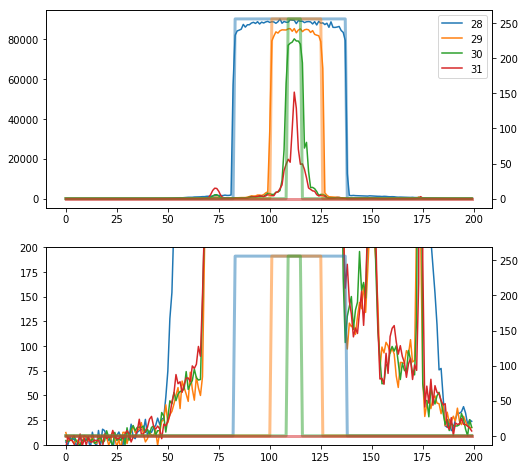

In [13]:
i = slice(22, 35)
fig, ax = plt.subplots(nrows=2, figsize=(8,8))
axt0 = ax[0].twinx()
axt1 = ax[1].twinx()

for i in np.arange(28,32):
    ax[0].plot(dat[:, i], label=i)
    out = axt0.plot(dq[:, i] & 256, lw=3, alpha=.5)
    ax[1].plot(dat[:, i])  
    out = axt1.plot(dq[:, i] & 256, lw=3, alpha=.5)
ax[1].set_ylim(0, 200)
out=ax[0].legend()

I played around with the plots above, plotting different regions in different scalings. If I need to make plots for a paper, I can revisit that and pick ranges that look good. My conclusion for this from looking at that is:

- If there is nothing else, in each column, just extend the regions marked with 256 by a few pixels. One or two might be enough, but for long bleed columns we are far away from the Cepheid so that does not matter much.
- For each column, the masked region should be at least as big as the 256 mask in the i-1 column (because readouts goes from left to right).
- Can't really see this in the center, because fluxes are so high anyway, but don't see anything contradicting this scheme

In `scipy.ndimage` there is a function `binary_dilation` which can be used to expand a mask array into a particular direction. So, we define the structure of the expansion (two pixels up and down and one to the right).

In [167]:
from scipy import ndimage
structure = [[False, True, False],
             [False, True, False], 
             [False, True, True], 
             [False, True, False], 
             [False, True, False]]

In [159]:
# Get a list of all flt and flc images
fllist = glob.glob(datapath + '*_fl?.fits')

# astrodrizzle back up files in a directory called "OrIg_files"
# If this directory is already populated, we'll have to modify all files in there, too because astrodrizzle
# will pull them down again from there
fllist.extend(glob.glob(os.path.join(datapath, 'OrIg_files', '*_fl?.fits')))

The code below modifies the files downloaded from the HST data archive. 
We set a new mask that is slightly bigger (with the kernel defined above) than the region masked as saturated by the pipeline. The pipeline set the data quality flag 256 for saturated pixels. Below, we introduce a new mask for "saturated or likely affected by the bleed from a saturated pixel" using the bitmask with value 16384, a bit that is unused in the HST pipeline (see http://www.stsci.edu/hst/wfc3/documents/handbooks/currentDHB/Chapter3_calibration3.html#547032 for a table listing the meaning of UVIS data quality flags).
To get back the original version, either download from MAST again, or simply reset the bit 16384 in the DQ arrays.

In [166]:
# Change the original files

for f in fllist:
    hdu = fits.open(f, mode='update')
    dq = hdu[3].data
    out = ndimage.binary_dilation(dq, structure=structure).astype(dq.dtype)
    hdu[3].data = dq | (out * 16384)
    hdu.flush()
    hdu.close()

## Use FLT or FLC images?

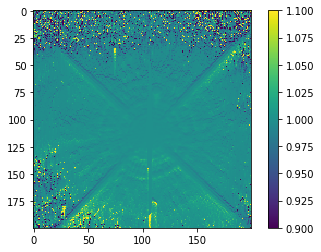

In [126]:
plt.imshow(hdus[1].data[400:600, 400:600]/hdusc[1].data[400:600, 400:600], vmin=0.9, vmax=1.1)
plt.colorbar()

I can't see much difference between the FLT and FLC images. That's fine, the CTE correction is supposed to be small for images with such high "background" (where background here means a lot of bright stuff in the pixels around it). I checked the images above in DS9, too. There are a few trails in the bottom below the bleed columns, but those pixels probably don't do much in term of producing spuorious sources - they need to be masked out in either case.

So, I think FLT images are the better choice here. According to the handbook, the CTE correction has a probability of introducing artifacts (http://www.stsci.edu/hst/wfc3/documents/handbooks/currentIHB/c06_uvis10.html#439253). Potentially introducing artifacts that might be detected as sources is worse a problem here than not correcting some small CTE problem. My guess is that the residuals from the PSF subtraction are much larger than CTE losses anyway.

/nfs/melkor/d1/guenther/soft/anaconda/envs/stsci/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


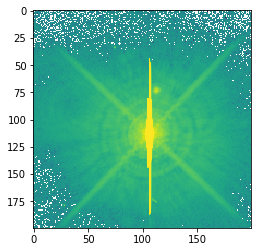

In [128]:
plt.imshow(np.log(hdus[1].data[400:600, 400:600]))

## Run astrodrizzle again and see if the new masking makes things better

In [182]:
asnfltlist = glob.glob(os.path.join(datapath, '*flt_asn.fits'))
for f in asnfltlist:
    astrodrizzle.AstroDrizzle(f, build=True)

Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 11:48:11.512 (25/01/2019)

==== Processing Step  Initialization  started at  11:48:11.516 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 122.99986034352303  -46.644359955718095  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : 1.0175208535901036e-05  -4.193732186346974e-06  
CD2_1 CD2_2  : -4.193732186346974e-06  -1.0175208535901036e-05  
NAXIS : 1035  1092
********************************************************************************
*
*  Estimated memory usage:  up to 62 Mb.
*  Output image size:       1035 X 1092 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         3
*
********************************************************************************
==== Processing Step  Initialization  finished at  11:48:12.885 (25/01/2019)

==== Processing Step  Static Mask  started at  11:48:12.889 (25/01/2019)
==== Processing Step  Stat

*  Cores available:         3
*
********************************************************************************
==== Processing Step  Initialization  finished at  11:48:22.10 (25/01/2019)

==== Processing Step  Static Mask  started at  11:48:22.109 (25/01/2019)
==== Processing Step  Static Mask  finished at  11:48:22.287 (25/01/2019)

==== Processing Step  Subtract Sky  started at  11:48:22.29 (25/01/2019)
***** skymatch started on 2019-01-25 11:48:22.402110
      Version 0.9.15 (2018-07-03 21:07:36 -0400)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ibg448pwq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg448pwq_skymatch_mask_sci1.fits


-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ibg413o1q_flt.fits'
       EXT: 'SCI',1;	MASK: ibg413o1q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg413o3q_flt.fits'
       EXT: 'SCI',1;	MASK: ibg413o3q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg413o5q_flt.fits'
       EXT: 'SCI',1;	MASK: ibg413o5q_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lower = None
       upper = None
       nclip = 5
       lsigma = 4.0
       usigma = 4.0
       binwidth = 0.1

-----  Data->Brightness conversion parameters for input files:  -----

   *   Image: ibg413o1q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 1.2 [s]
             Conversion factor (data->brightness):  530.8719666566228

   *   Image: ibg413o3q_flt.fits
       EXT = 'SCI',1
             Data un


   *   Image: ibg414m1q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 14.9 [s]
             Conversion factor (data->brightness):  42.75478926093606

   *   Image: ibg414m3q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 14.9 [s]
             Conversion factor (data->brightness):  42.75478926093606

   *   Image: ibg414m5q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 14.9 [s]
             Conversion factor (data->brightness):  42.75478926093606


-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'ibg414m1q_flt.fits['SCI',1]'  --  SKY = 38.861281500429605 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.908934   NEW MDRIZSKY = 0.908934
   *   Image:   'ibg414m3q_flt.fits['SCI',1]'  --  SKY = 49.8465087809691 (brightness units)
       Sky change (data units):
      - E

       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.681938   NEW MDRIZSKY = 0.681938
   *   Image:   'ibg453wxq_flt.fits['SCI',1]'  --  SKY = 51.46074670145491 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.234263   NEW MDRIZSKY = 0.234263
   *   Image:   'ibg453wzq_flt.fits['SCI',1]'  --  SKY = 82.38763058147104 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.37505   NEW MDRIZSKY = 0.37505
***** skymatch ended on 2019-01-25 11:48:52.018849
TOTAL RUN TIME: 0:00:00.394971
==== Processing Step  Subtract Sky  finished at  11:48:52.149 (25/01/2019)

==== Processing Step  Separate Drizzle  started at  11:48:52.152 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 273.26039207301943  -23.11727554086457  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -7.668160359265643e-06  -7.894401503880006e-06  
CD2_1 CD2_2  : -7.894401503880006e-06  7.66816

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 275.3457718352598  -18.859994435990053  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -8.251337957705147e-06  -7.282697323630177e-06  
CD2_1 CD2_2  : -7.282697323630177e-06  8.251337957705147e-06  
NAXIS : 1035  1092
-Generating simple FITS output: ibg452hqq_single_sci.fits
-Generating simple FITS output: ibg452hoq_single_sci.fits
-Generating simple FITS output: ibg452hsq_single_sci.fits
Writing out image to disk: ibg452hoq_single_sci.fits
Writing out image to disk: ibg452hqq_single_sci.fits
Writing out image to disk: ibg452hsq_single_sci.fits
Writing out image to disk: ibg452hoq_single_wht.fits
Writing out image to disk: ibg452hqq_single_wht.fits
Writing out image to disk: ibg452hsq_single_wht.fits
==== Processing Step  Separate Drizzle  finished at  11:49:03.153 (25/01/2019)

==== Processing Step  Create Median  started at  11:49:03.158 (25/01/2019)
reference sky value for image 'ibg452hoq_flt.fits' is 0.2509536147

Writing out image to disk: ibg445kzq_single_wht.fits
==== Processing Step  Separate Drizzle  finished at  11:49:12.698 (25/01/2019)

==== Processing Step  Create Median  started at  11:49:12.703 (25/01/2019)
reference sky value for image 'ibg445kvq_flt.fits' is 0.8658552169799805
reference sky value for image 'ibg445kxq_flt.fits' is 1.2337417602539062
reference sky value for image 'ibg445kzq_flt.fits' is 1.4002805948257446
Saving output median image to: 'ibg445020_med.fits'
==== Processing Step  Create Median  finished at  11:49:13.469 (25/01/2019)

==== Processing Step  Blot  started at  11:49:13.471 (25/01/2019)
    Blot: creating blotted image:  ibg445kvq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg445kvq_sci1_blt.fits
Writing out image to disk: ibg445kvq_sci1_blt.fits
    Blot: creating blotted image:  ibg445kxq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg445kxq_sci1_

-Generating simple FITS output: ibg460gxq_sci1_blt.fits
Writing out image to disk: ibg460gxq_sci1_blt.fits
    Blot: creating blotted image:  ibg460gzq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg460gzq_sci1_blt.fits
Writing out image to disk: ibg460gzq_sci1_blt.fits
    Blot: creating blotted image:  ibg460h1q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg460h1q_sci1_blt.fits
Writing out image to disk: ibg460h1q_sci1_blt.fits
==== Processing Step  Blot  finished at  11:49:25.682 (25/01/2019)

==== Processing Step  Driz_CR  started at  11:49:25.684 (25/01/2019)
Removed old cosmic ray mask file: ibg460gxq_sci1_crmask.fits
Creating output :  ibg460gxq_sci1_crmask.fits
Removed old cosmic ray mask file: ibg460gzq_sci1_crmask.fits
Creating output :  ibg460gzq_sci1_crmask.fits
Removed old cosmic ray mask file: ibg460h1q_sci1_crmask.fits
Creating output :  ibg460h1q_sci1_crmask.fi

Creating output :  ibg465n7q_sci1_crmask.fits
Removed old cosmic ray mask file: ibg465n9q_sci1_crmask.fits
Creating output :  ibg465n9q_sci1_crmask.fits
Removed old cosmic ray mask file: ibg465nbq_sci1_crmask.fits
Creating output :  ibg465nbq_sci1_crmask.fits
==== Processing Step  Driz_CR  finished at  11:49:36.498 (25/01/2019)

==== Processing Step  Final Drizzle  started at  11:49:36.516 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 232.7076140338073  -65.5993334756765  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : 8.546122747945339e-06  6.934410167918184e-06  
CD2_1 CD2_2  : 6.934410167918184e-06  -8.546122747945339e-06  
NAXIS : 1035  1092
-Generating multi-extension output file:  ibg465010_drz.fits
Writing out to disk: ibg465010_drz.fits
==== Processing Step  Final Drizzle  finished at  11:49:39.635 (25/01/2019)


AstroDrizzle Version 2.2.6 is finished processing at 11:49:39.637 (25/01/2019).


   --------------------          -----------------

-Generating multi-extension output file:  ibg420020_drz.fits
Writing out to disk: ibg420020_drz.fits
==== Processing Step  Final Drizzle  finished at  11:49:49.368 (25/01/2019)


AstroDrizzle Version 2.2.6 is finished processing at 11:49:49.372 (25/01/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.1187 sec.
            Static Mask          0.1606 sec.
           Subtract Sky          0.6407 sec.
       Separate Drizzle          1.0494 sec.
          Create Median          0.5780 sec.
                   Blot          1.6964 sec.
                Driz_CR          1.1193 sec.
          Final Drizzle          3.1665 sec.
   ====================          ====================
                  Total          9.5295 sec.
Trailer file written to:  astrodrizzle.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.6 (2018-11-02 15:3

                Driz_CR          1.1094 sec.
          Final Drizzle          3.3321 sec.
   ====================          ====================
                  Total          9.1238 sec.
Trailer file written to:  astrodrizzle.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 11:49:58.850 (25/01/2019)

==== Processing Step  Initialization  started at  11:49:58.853 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 254.58228294460574  -33.60910029723425  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -9.506598980318594e-06  -5.544982797744405e-06  
CD2_1 CD2_2  : -5.544982797744405e-06  9.506598980318594e-06  
NAXIS : 1035  1092
********************************************************************************
*
*  Estimated memory usage:  up to 62 Mb.
*  Output image size:       1035 X 1092 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         3
*
*****************************

NAXIS : 1035  1092
********************************************************************************
*
*  Estimated memory usage:  up to 62 Mb.
*  Output image size:       1035 X 1092 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         3
*
********************************************************************************
==== Processing Step  Initialization  finished at  11:50:09.466 (25/01/2019)

==== Processing Step  Static Mask  started at  11:50:09.469 (25/01/2019)
==== Processing Step  Static Mask  finished at  11:50:09.592 (25/01/2019)

==== Processing Step  Subtract Sky  started at  11:50:09.594 (25/01/2019)
***** skymatch started on 2019-01-25 11:50:09.690627
      Version 0.9.15 (2018-07-03 21:07:36 -0400)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User spe

      Version 0.9.15 (2018-07-03 21:07:36 -0400)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ibg421gpq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg421gpq_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg421grq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg421grq_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg421gtq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg421gtq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lower = None
       upper = None
       nclip = 5
       lsigma = 4.0
       usigma = 4.0
       binwidth = 0.1

-----  Data->Brightness conversion parameters for

       EXT: 'SCI',1;	MASK: ibg401c7q_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lower = None
       upper = None
       nclip = 5
       lsigma = 4.0
       usigma = 4.0
       binwidth = 0.1

-----  Data->Brightness conversion parameters for input files:  -----

   *   Image: ibg401c3q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 4.5 [s]
             Conversion factor (data->brightness):  141.5658577750994

   *   Image: ibg401c5q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 4.5 [s]
             Conversion factor (data->brightness):  141.5658577750994

   *   Image: ibg401c7q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 4.5 [s]
             Conversion factor (data->brightness):  141.5658577750994


-----  Computing sky values requested image extensions (detector chips):  -----

   *   I


   *   Image: ibg416i8q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 2.6 [s]
             Conversion factor (data->brightness):  245.01783076459512


-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'ibg416i4q_flt.fits['SCI',1]'  --  SKY = 168.70658812533637 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.688548   NEW MDRIZSKY = 0.688548
   *   Image:   'ibg416i6q_flt.fits['SCI',1]'  --  SKY = 139.40543531354825 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.56896   NEW MDRIZSKY = 0.56896
   *   Image:   'ibg416i8q_flt.fits['SCI',1]'  --  SKY = 127.37864231523815 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.519875   NEW MDRIZSKY = 0.519875
***** skymatch ended on 2019-01-25 11:50:38.189623
TOTAL RUN TIME: 0:00:00.405170
==== Processing Step  Subtract S

   *   Image:   'ibg445kyq_flt.fits['SCI',1]'  --  SKY = 29.95255002168763 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.136352   NEW MDRIZSKY = 0.136352
***** skymatch ended on 2019-01-25 11:50:47.693983
TOTAL RUN TIME: 0:00:00.430923
==== Processing Step  Subtract Sky  finished at  11:50:47.787 (25/01/2019)

==== Processing Step  Separate Drizzle  started at  11:50:47.789 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 123.26756355478147  -34.578535753573945  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : 9.939541389321885e-06  -4.725227546884176e-06  
CD2_1 CD2_2  : -4.725227546884176e-06  -9.939541389321885e-06  
NAXIS : 1035  1092
-Generating simple FITS output: ibg445kuq_single_sci.fits
-Generating simple FITS output: ibg445kwq_single_sci.fits
Writing out image to disk: ibg445kuq_single_sci.fits
-Generating simple FITS output: ibg445kyq_single_sci.fits
Writing out image to disk: ibg445kwq_single_sc

NAXIS : 1035  1092
-Generating simple FITS output: ibg435rjq_single_sci.fits
-Generating simple FITS output: ibg435rnq_single_sci.fits
Writing out image to disk: ibg435rjq_single_sci.fits
-Generating simple FITS output: ibg435rlq_single_sci.fits
Writing out image to disk: ibg435rnq_single_sci.fits
Writing out image to disk: ibg435rjq_single_wht.fits
Writing out image to disk: ibg435rlq_single_sci.fits
Writing out image to disk: ibg435rnq_single_wht.fits
Writing out image to disk: ibg435rlq_single_wht.fits
==== Processing Step  Separate Drizzle  finished at  11:50:58.856 (25/01/2019)

==== Processing Step  Create Median  started at  11:50:58.860 (25/01/2019)
reference sky value for image 'ibg435rjq_flt.fits' is 0.7143237590789795
reference sky value for image 'ibg435rlq_flt.fits' is 1.2869224548339844
reference sky value for image 'ibg435rnq_flt.fits' is 0.7106156945228577
Saving output median image to: 'ibg435010_med.fits'
==== Processing Step  Create Median  finished at  11:50:59.463 

reference sky value for image 'ibg418ovq_flt.fits' is 0.250690221786499
reference sky value for image 'ibg418oxq_flt.fits' is 0.3050563633441925
Saving output median image to: 'ibg418010_med.fits'
==== Processing Step  Create Median  finished at  11:51:09.09 (25/01/2019)

==== Processing Step  Blot  started at  11:51:09.101 (25/01/2019)
    Blot: creating blotted image:  ibg418otq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg418otq_sci1_blt.fits
Writing out image to disk: ibg418otq_sci1_blt.fits
    Blot: creating blotted image:  ibg418ovq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg418ovq_sci1_blt.fits
Writing out image to disk: ibg418ovq_sci1_blt.fits
    Blot: creating blotted image:  ibg418oxq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg418oxq_sci1_blt.fits
Writing out image to disk: ibg418oxq_sci1_blt.fits
====

Writing out image to disk: ibg460gyq_sci1_blt.fits
    Blot: creating blotted image:  ibg460h0q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg460h0q_sci1_blt.fits
Writing out image to disk: ibg460h0q_sci1_blt.fits
==== Processing Step  Blot  finished at  11:51:20.0 (25/01/2019)

==== Processing Step  Driz_CR  started at  11:51:20.098 (25/01/2019)
Removed old cosmic ray mask file: ibg460gwq_sci1_crmask.fits
Removed old cosmic ray mask file: ibg460gyq_sci1_crmask.fits
Creating output :  ibg460gwq_sci1_crmask.fits
Creating output :  ibg460gyq_sci1_crmask.fits
Removed old cosmic ray mask file: ibg460h0q_sci1_crmask.fits
Creating output :  ibg460h0q_sci1_crmask.fits
==== Processing Step  Driz_CR  finished at  11:51:21.216 (25/01/2019)

==== Processing Step  Final Drizzle  started at  11:51:21.240 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 279.46295991069627  -6.796811491153082  
CRPIX : 51

==== Processing Step  Driz_CR  finished at  11:51:31.372 (25/01/2019)

==== Processing Step  Final Drizzle  started at  11:51:31.388 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 97.14202947323781  30.49303923203816  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -8.569570951072474e-06  -6.9054117990465065e-06  
CD2_1 CD2_2  : -6.9054117990465065e-06  8.569570951072474e-06  
NAXIS : 1035  1092
-Generating multi-extension output file:  ibg408010_drz.fits
Writing out to disk: ibg408010_drz.fits
==== Processing Step  Final Drizzle  finished at  11:51:34.876 (25/01/2019)


AstroDrizzle Version 2.2.6 is finished processing at 11:51:34.879 (25/01/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.2145 sec.
            Static Mask          0.1243 sec.
           Subtract Sky          0.6605 sec.
       Separate 



   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.1615 sec.
            Static Mask          0.1240 sec.
           Subtract Sky          0.6128 sec.
       Separate Drizzle          1.0514 sec.
          Create Median          0.5638 sec.
                   Blot          1.4286 sec.
                Driz_CR          1.1103 sec.
          Final Drizzle          2.9081 sec.
   ====================          ====================
                  Total          8.9605 sec.
Trailer file written to:  astrodrizzle.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 11:51:44.21 (25/01/2019)

==== Processing Step  Initialization  started at  11:51:44.213 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 158.2952021486149  -58.4986397150272  
CRPIX : 517.5  54

AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 11:51:54.243 (25/01/2019)

==== Processing Step  Initialization  started at  11:51:54.245 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 241.82916715146797  -62.91055273383337  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -8.216609515597195e-06  -7.321856763695497e-06  
CD2_1 CD2_2  : -7.321856763695497e-06  8.216609515597195e-06  
NAXIS : 1035  1092
********************************************************************************
*
*  Estimated memory usage:  up to 62 Mb.
*  Output image size:       1035 X 1092 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         3
*
********************************************************************************
==== Processing Step  Initialization  finished at  11:51:55.357 (25/01/2019)

==== Processing Step  Static Mask  started at  11:51:55.360 (25/01/2019)
==== Processing Step  Static Mask  finished at  11:51:55.484 (25/01/

*
********************************************************************************
==== Processing Step  Initialization  finished at  11:52:04.65 (25/01/2019)

==== Processing Step  Static Mask  started at  11:52:04.660 (25/01/2019)
==== Processing Step  Static Mask  finished at  11:52:04.848 (25/01/2019)

==== Processing Step  Subtract Sky  started at  11:52:04.850 (25/01/2019)
***** skymatch started on 2019-01-25 11:52:05.004811
      Version 0.9.15 (2018-07-03 21:07:36 -0400)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ibg417a1q_flt.fits'
       EXT: 'SCI',1;	MASK: ibg417a1q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg


-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ibg418ouq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg418ouq_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg418owq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg418owq_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg418oyq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg418oyq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lower = None
       upper = None
       nclip = 5
       lsigma = 4.0
       usigma = 4.0
       binwidth = 0.1

-----  Data->Brightness conversion parameters for input files:  -----

   *   Image: ibg418ouq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 5.2 [s]
             Conversion factor (data->brightness):  122.50891538229756

   *   Image: ibg418owq_flt.fits
       EXT = 'SCI',1
             Data u


   *   Image: ibg427snq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 5.1 [s]
             Conversion factor (data->brightness):  124.9110509780289

   *   Image: ibg427spq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 5.1 [s]
             Conversion factor (data->brightness):  124.9110509780289

   *   Image: ibg427srq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 5.1 [s]
             Conversion factor (data->brightness):  124.9110509780289


-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'ibg427snq_flt.fits['SCI',1]'  --  SKY = 73.15349772286481 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.585645   NEW MDRIZSKY = 0.585645
   *   Image:   'ibg427spq_flt.fits['SCI',1]'  --  SKY = 75.01036515164576 (brightness units)
       Sky change (data units):
      - EXT 

       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.448807   NEW MDRIZSKY = 0.448807
   *   Image:   'ibg426d9q_flt.fits['SCI',1]'  --  SKY = 143.78380253394988 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.19623   NEW MDRIZSKY = 1.19623
   *   Image:   'ibg426dbq_flt.fits['SCI',1]'  --  SKY = 136.70937557859614 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.13737   NEW MDRIZSKY = 1.13737
***** skymatch ended on 2019-01-25 11:52:33.732990
TOTAL RUN TIME: 0:00:00.351689
==== Processing Step  Subtract Sky  finished at  11:52:33.828 (25/01/2019)

==== Processing Step  Separate Drizzle  started at  11:52:33.830 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 193.59164402308346  -58.430609418839346  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -4.5590292361457e-06  -1.0016861325976548e-05  
CD2_1 CD2_2  : -1.0016861325976548e-05  4.5590

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 229.94045601767579  -66.49602898525352  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -4.37252510022876e-06  -1.0099667452334526e-05  
CD2_1 CD2_2  : -1.0099667452334526e-05  4.37252510022876e-06  
NAXIS : 1035  1092
-Generating simple FITS output: ibg462i3q_single_sci.fits
-Generating simple FITS output: ibg462i7q_single_sci.fits
-Generating simple FITS output: ibg462i5q_single_sci.fits
Writing out image to disk: ibg462i3q_single_sci.fits
Writing out image to disk: ibg462i7q_single_sci.fits
Writing out image to disk: ibg462i5q_single_sci.fits
Writing out image to disk: ibg462i3q_single_wht.fits
Writing out image to disk: ibg462i7q_single_wht.fits
Writing out image to disk: ibg462i5q_single_wht.fits
==== Processing Step  Separate Drizzle  finished at  11:52:44.703 (25/01/2019)

==== Processing Step  Create Median  started at  11:52:44.708 (25/01/2019)
reference sky value for image 'ibg462i3q_flt.fits' is 0.6701650619

Writing out image to disk: ibg447rvq_single_wht.fits
==== Processing Step  Separate Drizzle  finished at  11:52:54.159 (25/01/2019)

==== Processing Step  Create Median  started at  11:52:54.167 (25/01/2019)
reference sky value for image 'ibg447rrq_flt.fits' is 0.4256911873817444
reference sky value for image 'ibg447rtq_flt.fits' is 0.34732574224472046
reference sky value for image 'ibg447rvq_flt.fits' is 0.6483811140060425
Saving output median image to: 'ibg447020_med.fits'
==== Processing Step  Create Median  finished at  11:52:54.724 (25/01/2019)

==== Processing Step  Blot  started at  11:52:54.726 (25/01/2019)
    Blot: creating blotted image:  ibg447rrq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg447rrq_sci1_blt.fits
Writing out image to disk: ibg447rrq_sci1_blt.fits
    Blot: creating blotted image:  ibg447rtq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg447rtq_sci1

Using default C-based coordinate transformation...
-Generating simple FITS output: ibg409r3q_sci1_blt.fits
Writing out image to disk: ibg409r3q_sci1_blt.fits
    Blot: creating blotted image:  ibg409r5q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg409r5q_sci1_blt.fits
Writing out image to disk: ibg409r5q_sci1_blt.fits
    Blot: creating blotted image:  ibg409r7q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg409r7q_sci1_blt.fits
Writing out image to disk: ibg409r7q_sci1_blt.fits
==== Processing Step  Blot  finished at  11:53:05.978 (25/01/2019)

==== Processing Step  Driz_CR  started at  11:53:05.980 (25/01/2019)
Removed old cosmic ray mask file: ibg409r3q_sci1_crmask.fits
Creating output :  ibg409r3q_sci1_crmask.fits
Removed old cosmic ray mask file: ibg409r5q_sci1_crmask.fits
Creating output :  ibg409r5q_sci1_crmask.fits
Removed old cosmic ray mask file: ibg409r7q_sci1_crma

Removed old cosmic ray mask file: ibg415keq_sci1_crmask.fits
Creating output :  ibg415keq_sci1_crmask.fits
Removed old cosmic ray mask file: ibg415kgq_sci1_crmask.fits
Creating output :  ibg415kgq_sci1_crmask.fits
Removed old cosmic ray mask file: ibg415kiq_sci1_crmask.fits
Creating output :  ibg415kiq_sci1_crmask.fits
==== Processing Step  Driz_CR  finished at  11:53:16.561 (25/01/2019)

==== Processing Step  Final Drizzle  started at  11:53:16.583 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 23.180091415128896  63.59380779197774  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -7.69743550248068e-06  -7.865859462577874e-06  
CD2_1 CD2_2  : -7.865859462577874e-06  7.69743550248068e-06  
NAXIS : 1035  1092
-Generating multi-extension output file:  ibg415010_drz.fits
Writing out to disk: ibg415010_drz.fits
==== Processing Step  Final Drizzle  finished at  11:53:20.004 (25/01/2019)


AstroDrizzle Version 2.2.6 is finished processing at 11:53:20.007 (25/

NAXIS : 1035  1092
-Generating multi-extension output file:  ibg428020_drz.fits
Writing out to disk: ibg428020_drz.fits
==== Processing Step  Final Drizzle  finished at  11:53:29.856 (25/01/2019)


AstroDrizzle Version 2.2.6 is finished processing at 11:53:29.858 (25/01/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.3604 sec.
            Static Mask          0.1387 sec.
           Subtract Sky          0.6012 sec.
       Separate Drizzle          1.0428 sec.
          Create Median          0.5368 sec.
                   Blot          1.6287 sec.
                Driz_CR          1.1127 sec.
          Final Drizzle          3.1965 sec.
   ====================          ====================
                  Total          9.6179 sec.
Trailer file written to:  astrodrizzle.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2

                Driz_CR          1.1105 sec.
          Final Drizzle          2.9228 sec.
   ====================          ====================
                  Total          8.8301 sec.
Trailer file written to:  astrodrizzle.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 11:53:39.050 (25/01/2019)

==== Processing Step  Initialization  started at  11:53:39.054 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 190.52094749791098  -69.40756095781673  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : 1.0993345250907495e-05  -5.182842793540307e-07  
CD2_1 CD2_2  : -5.182842793540307e-07  -1.0993345250907495e-05  
NAXIS : 1035  1092
********************************************************************************
*
*  Estimated memory usage:  up to 62 Mb.
*  Output image size:       1035 X 1092 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         3
*
***************************

NAXIS : 1035  1092
********************************************************************************
*
*  Estimated memory usage:  up to 62 Mb.
*  Output image size:       1035 X 1092 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         3
*
********************************************************************************
==== Processing Step  Initialization  finished at  11:53:49.567 (25/01/2019)

==== Processing Step  Static Mask  started at  11:53:49.570 (25/01/2019)
==== Processing Step  Static Mask  finished at  11:53:49.752 (25/01/2019)

==== Processing Step  Subtract Sky  started at  11:53:49.754 (25/01/2019)
***** skymatch started on 2019-01-25 11:53:49.904529
      Version 0.9.15 (2018-07-03 21:07:36 -0400)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User spe

      Version 0.9.15 (2018-07-03 21:07:36 -0400)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ibg455ftq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg455ftq_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg455fvq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg455fvq_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg455fxq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg455fxq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lower = None
       upper = None
       nclip = 5
       lsigma = 4.0
       usigma = 4.0
       binwidth = 0.1

-----  Data->Brightness conversion parameters for

       EXT: 'SCI',1;	MASK: ibg433n2q_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lower = None
       upper = None
       nclip = 5
       lsigma = 4.0
       usigma = 4.0
       binwidth = 0.1

-----  Data->Brightness conversion parameters for input files:  -----

   *   Image: ibg433myq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 0.48 [s]
             Conversion factor (data->brightness):  1327.179916641557

   *   Image: ibg433n0q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 0.48 [s]
             Conversion factor (data->brightness):  1327.179916641557

   *   Image: ibg433n2q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 0.48 [s]
             Conversion factor (data->brightness):  1327.179916641557


-----  Computing sky values requested image extensions (detector chips):  -----

   * 


   *   Image: ibg454i3q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 2.9 [s]
             Conversion factor (data->brightness):  219.67115861653357


-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'ibg454hzq_flt.fits['SCI',1]'  --  SKY = 230.8736804517277 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.051   NEW MDRIZSKY = 1.051
   *   Image:   'ibg454i1q_flt.fits['SCI',1]'  --  SKY = 56.27679513908905 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.256187   NEW MDRIZSKY = 0.256187
   *   Image:   'ibg454i3q_flt.fits['SCI',1]'  --  SKY = 137.69314262941236 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.626815   NEW MDRIZSKY = 0.626815
***** skymatch ended on 2019-01-25 11:54:18.712371
TOTAL RUN TIME: 0:00:00.399686
==== Processing Step  Subtract Sky  fi

       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.432518   NEW MDRIZSKY = 0.432518
***** skymatch ended on 2019-01-25 11:54:27.967459
TOTAL RUN TIME: 0:00:00.375185
==== Processing Step  Subtract Sky  finished at  11:54:28.07 (25/01/2019)

==== Processing Step  Separate Drizzle  started at  11:54:28.077 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 119.44029792389011  -40.123365198416195  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : 9.906561200811174e-06  -4.7939861883883795e-06  
CD2_1 CD2_2  : -4.7939861883883795e-06  -9.906561200811174e-06  
NAXIS : 1035  1092
-Generating simple FITS output: ibg446e3q_single_sci.fits
-Generating simple FITS output: ibg446e1q_single_sci.fits
-Generating simple FITS output: ibg446e5q_single_sci.fits
Writing out image to disk: ibg446e3q_single_sci.fits
Writing out image to disk: ibg446e1q_single_sci.fits
Writing out image to disk: ibg446e5q_single_sci.fits
Writing out image to disk: ibg446

-Generating simple FITS output: ibg439p5q_single_sci.fits
-Generating simple FITS output: ibg439p7q_single_sci.fits
Writing out image to disk: ibg439p3q_single_sci.fits
Writing out image to disk: ibg439p5q_single_sci.fits
Writing out image to disk: ibg439p7q_single_sci.fits
Writing out image to disk: ibg439p3q_single_wht.fits
Writing out image to disk: ibg439p5q_single_wht.fits
Writing out image to disk: ibg439p7q_single_wht.fits
==== Processing Step  Separate Drizzle  finished at  11:54:38.59 (25/01/2019)

==== Processing Step  Create Median  started at  11:54:38.596 (25/01/2019)
reference sky value for image 'ibg439p3q_flt.fits' is 0.1390465945005417
reference sky value for image 'ibg439p5q_flt.fits' is 0.7578940987586975
reference sky value for image 'ibg439p7q_flt.fits' is 0.2116653174161911
Saving output median image to: 'ibg439010_med.fits'
==== Processing Step  Create Median  finished at  11:54:39.130 (25/01/2019)

==== Processing Step  Blot  started at  11:54:39.132 (25/01/2019

reference sky value for image 'ibg407mpq_flt.fits' is 0.9941726326942445
Saving output median image to: 'ibg407010_med.fits'
==== Processing Step  Create Median  finished at  11:54:48.644 (25/01/2019)

==== Processing Step  Blot  started at  11:54:48.646 (25/01/2019)
    Blot: creating blotted image:  ibg407mlq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg407mlq_sci1_blt.fits
Writing out image to disk: ibg407mlq_sci1_blt.fits
    Blot: creating blotted image:  ibg407mnq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg407mnq_sci1_blt.fits
Writing out image to disk: ibg407mnq_sci1_blt.fits
    Blot: creating blotted image:  ibg407mpq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg407mpq_sci1_blt.fits
Writing out image to disk: ibg407mpq_sci1_blt.fits
==== Processing Step  Blot  finished at  11:54:50.315 (25/01/2019)

==== Pr

    Blot: creating blotted image:  ibg417a6q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg417a6q_sci1_blt.fits
Writing out image to disk: ibg417a6q_sci1_blt.fits
==== Processing Step  Blot  finished at  11:55:00.047 (25/01/2019)

==== Processing Step  Driz_CR  started at  11:55:00.049 (25/01/2019)
Removed old cosmic ray mask file: ibg417a2q_sci1_crmask.fits
Creating output :  ibg417a2q_sci1_crmask.fits
Removed old cosmic ray mask file: ibg417a4q_sci1_crmask.fits
Creating output :  ibg417a4q_sci1_crmask.fits
Removed old cosmic ray mask file: ibg417a6q_sci1_crmask.fits
Creating output :  ibg417a6q_sci1_crmask.fits
==== Processing Step  Driz_CR  finished at  11:55:01.15 (25/01/2019)

==== Processing Step  Final Drizzle  started at  11:55:01.182 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 221.64013698685076  -32.17089820401098  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -4.758155170195606e-06


==== Processing Step  Final Drizzle  started at  11:55:11.029 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 221.6749059262493  -61.46193608472013  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -8.23677491303702e-06  -7.299164159808975e-06  
CD2_1 CD2_2  : -7.299164159808975e-06  8.23677491303702e-06  
NAXIS : 1035  1092
-Generating multi-extension output file:  ibg424010_drz.fits
Writing out to disk: ibg424010_drz.fits
==== Processing Step  Final Drizzle  finished at  11:55:14.095 (25/01/2019)


AstroDrizzle Version 2.2.6 is finished processing at 11:55:14.099 (25/01/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.1119 sec.
            Static Mask          0.1639 sec.
           Subtract Sky          0.5830 sec.
       Separate Drizzle          1.3694 sec.
          Create Median          0.8993 sec.

                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.4601 sec.
            Static Mask          0.1634 sec.
           Subtract Sky          0.6717 sec.
       Separate Drizzle          1.0560 sec.
          Create Median          0.7733 sec.
                   Blot          1.5013 sec.
                Driz_CR          1.1114 sec.
          Final Drizzle          2.9698 sec.
   ====================          ====================
                  Total          9.7070 sec.
Trailer file written to:  astrodrizzle.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 11:55:24.213 (25/01/2019)

==== Processing Step  Initialization  started at  11:55:24.216 (25/01/2019)
Preserving original of:  ibg441mjq_flt.fits as  OrIg_files/ibg441mjq_flt.fits
Preserving original of:  ibg441n4q_flt.fits as  OrIg_files/ibg441n4q_flt.fits
Preserving original of:  ibg441n

AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 11:55:33.716 (25/01/2019)

==== Processing Step  Initialization  started at  11:55:33.719 (25/01/2019)
Preserving original of:  ibg451yvq_flt.fits as  OrIg_files/ibg451yvq_flt.fits
Preserving original of:  ibg451yyq_flt.fits as  OrIg_files/ibg451yyq_flt.fits
Preserving original of:  ibg451z0q_flt.fits as  OrIg_files/ibg451z0q_flt.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 266.8900955742047  -27.830784043596825  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -7.472181064598667e-06  -8.080146566599458e-06  
CD2_1 CD2_2  : -8.080146566599458e-06  7.472181064598667e-06  
NAXIS : 1035  1092
********************************************************************************
*
*  Estimated memory usage:  up to 62 Mb.
*  Output image size:       1035 X 1092 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         3
*
******************************************************************

NAXIS : 1035  1092
********************************************************************************
*
*  Estimated memory usage:  up to 62 Mb.
*  Output image size:       1035 X 1092 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         3
*
********************************************************************************
==== Processing Step  Initialization  finished at  11:55:44.264 (25/01/2019)

==== Processing Step  Static Mask  started at  11:55:44.267 (25/01/2019)
==== Processing Step  Static Mask  finished at  11:55:44.391 (25/01/2019)

==== Processing Step  Subtract Sky  started at  11:55:44.393 (25/01/2019)
***** skymatch started on 2019-01-25 11:55:44.488648
      Version 0.9.15 (2018-07-03 21:07:36 -0400)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User spe

***** skymatch started on 2019-01-25 11:55:54.467863
      Version 0.9.15 (2018-07-03 21:07:36 -0400)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ibg423mlq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg423mlq_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg423mnq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg423mnq_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg423mpq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg423mpq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lower = None
       upper = None
       nclip = 5
       lsigma = 4.0
       usigma = 4.0
       binwidth = 0

       EXT: 'SCI',1;	MASK: ibg433n1q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg433n3q_flt.fits'
       EXT: 'SCI',1;	MASK: ibg433n3q_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lower = None
       upper = None
       nclip = 5
       lsigma = 4.0
       usigma = 4.0
       binwidth = 0.1

-----  Data->Brightness conversion parameters for input files:  -----

   *   Image: ibg433mzq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 0.48 [s]
             Conversion factor (data->brightness):  1327.179916641557

   *   Image: ibg433n1q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 0.48 [s]
             Conversion factor (data->brightness):  1327.179916641557

   *   Image: ibg433n3q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 0.48 [s]
             Conversion factor (data->brightness):  


   *   Image: ibg466yiq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 5.2 [s]
             Conversion factor (data->brightness):  122.50891538229756

   *   Image: ibg466ykq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 5.2 [s]
             Conversion factor (data->brightness):  122.50891538229756


-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'ibg466ygq_flt.fits['SCI',1]'  --  SKY = 91.35889265978938 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.745733   NEW MDRIZSKY = 0.745733
   *   Image:   'ibg466yiq_flt.fits['SCI',1]'  --  SKY = 29.23387125885747 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.238626   NEW MDRIZSKY = 0.238626
   *   Image:   'ibg466ykq_flt.fits['SCI',1]'  --  SKY = 55.08731911947606 (brightness units)
       Sky change (data units):

   *   Image:   'ibg422i6q_flt.fits['SCI',1]'  --  SKY = 58.33859175450585 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.03482   NEW MDRIZSKY = 1.03482
   *   Image:   'ibg422i8q_flt.fits['SCI',1]'  --  SKY = 51.520317944976526 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.913873   NEW MDRIZSKY = 0.913873
***** skymatch ended on 2019-01-25 11:56:24.468350
TOTAL RUN TIME: 0:00:00.390773
==== Processing Step  Subtract Sky  finished at  11:56:24.559 (25/01/2019)

==== Processing Step  Separate Drizzle  started at  11:56:24.562 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 222.6262153858025  -67.49762072183995  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : 3.0678839399130246e-06  -1.0569311544802699e-05  
CD2_1 CD2_2  : -1.0569311544802699e-05  -3.0678839399130246e-06  
NAXIS : 1035  1092
-Generating simple FITS output: ibg422i8q_single_sci.fits
Writing out

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 35.96560003851362  55.36486966711694  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -1.0956086601126628e-05  -1.04231702878224e-06  
CD2_1 CD2_2  : -1.04231702878224e-06  1.0956086601126628e-05  
NAXIS : 1035  1092
-Generating simple FITS output: ibg444r4q_single_sci.fits
-Generating simple FITS output: ibg444r6q_single_sci.fits
-Generating simple FITS output: ibg444r8q_single_sci.fits
Writing out image to disk: ibg444r4q_single_sci.fits
Writing out image to disk: ibg444r6q_single_sci.fits
Writing out image to disk: ibg444r4q_single_wht.fits
Writing out image to disk: ibg444r8q_single_sci.fits
Writing out image to disk: ibg444r6q_single_wht.fits
Writing out image to disk: ibg444r8q_single_wht.fits
==== Processing Step  Separate Drizzle  finished at  11:56:35.280 (25/01/2019)

==== Processing Step  Create Median  started at  11:56:35.290 (25/01/2019)
reference sky value for image 'ibg444r4q_flt.fits' is 0.198069110512

Writing out image to disk: ibg440gsq_single_wht.fits
Writing out image to disk: ibg440gqq_single_wht.fits
==== Processing Step  Separate Drizzle  finished at  11:56:44.547 (25/01/2019)

==== Processing Step  Create Median  started at  11:56:44.550 (25/01/2019)
reference sky value for image 'ibg440goq_flt.fits' is 0.46874910593032837
reference sky value for image 'ibg440gqq_flt.fits' is 0.9031918048858643
reference sky value for image 'ibg440gsq_flt.fits' is 0.9799270033836366
Saving output median image to: 'ibg440020_med.fits'
==== Processing Step  Create Median  finished at  11:56:45.314 (25/01/2019)

==== Processing Step  Blot  started at  11:56:45.316 (25/01/2019)
    Blot: creating blotted image:  ibg440goq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg440goq_sci1_blt.fits
Writing out image to disk: ibg440goq_sci1_blt.fits
    Blot: creating blotted image:  ibg440gqq_flt.fits[sci,1]
Using default C-based coordinate transformat

    Blot: creating blotted image:  ibg457riq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg457riq_sci1_blt.fits
Writing out image to disk: ibg457riq_sci1_blt.fits
    Blot: creating blotted image:  ibg457rkq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg457rkq_sci1_blt.fits
Writing out image to disk: ibg457rkq_sci1_blt.fits
    Blot: creating blotted image:  ibg457rmq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg457rmq_sci1_blt.fits
Writing out image to disk: ibg457rmq_sci1_blt.fits
==== Processing Step  Blot  finished at  11:56:57.387 (25/01/2019)

==== Processing Step  Driz_CR  started at  11:56:57.389 (25/01/2019)
Creating output :  ibg457riq_sci1_crmask.fits
Creating output :  ibg457rmq_sci1_crmask.fits
Creating output :  ibg457rkq_sci1_crmask.fits
==== Processing Step  Driz_CR  finished at  11:56:58.485 (25/01/2019

==== Processing Step  Blot  finished at  11:57:06.995 (25/01/2019)

==== Processing Step  Driz_CR  started at  11:57:06.996 (25/01/2019)
Creating output :  ibg443kjq_sci1_crmask.fits
Creating output :  ibg443klq_sci1_crmask.fits
Creating output :  ibg443knq_sci1_crmask.fits
==== Processing Step  Driz_CR  finished at  11:57:08.103 (25/01/2019)

==== Processing Step  Final Drizzle  started at  11:57:08.1 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 71.94299081572967  36.72278902772144  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : 5.51882359223208e-06  9.521808891051033e-06  
CD2_1 CD2_2  : 9.521808891051033e-06  -5.51882359223208e-06  
NAXIS : 1035  1092
-Generating multi-extension output file:  ibg443020_drz.fits
Writing out to disk: ibg443020_drz.fits
==== Processing Step  Final Drizzle  finished at  11:57:11.218 (25/01/2019)


AstroDrizzle Version 2.2.6 is finished processing at 11:57:11.220 (25/01/2019).


   --------------------          ------

NAXIS : 1035  1092
-Generating multi-extension output file:  ibg469020_drz.fits
Writing out to disk: ibg469020_drz.fits
==== Processing Step  Final Drizzle  finished at  11:57:21.473 (25/01/2019)


AstroDrizzle Version 2.2.6 is finished processing at 11:57:21.477 (25/01/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.5065 sec.
            Static Mask          0.1235 sec.
           Subtract Sky          0.8955 sec.
       Separate Drizzle          1.0411 sec.
          Create Median          0.7213 sec.
                   Blot          1.5094 sec.
                Driz_CR          1.1058 sec.
          Final Drizzle          3.1225 sec.
   ====================          ====================
                  Total          10.0256 sec.
Trailer file written to:  astrodrizzle.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.

                   Blot          1.3455 sec.
                Driz_CR          1.1027 sec.
          Final Drizzle          2.9286 sec.
   ====================          ====================
                  Total          9.1877 sec.
Trailer file written to:  astrodrizzle.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 11:57:31.049 (25/01/2019)

==== Processing Step  Initialization  started at  11:57:31.052 (25/01/2019)
Preserving original of:  ibg422i3q_flt.fits as  OrIg_files/ibg422i3q_flt.fits
Preserving original of:  ibg422i5q_flt.fits as  OrIg_files/ibg422i5q_flt.fits
Preserving original of:  ibg422i7q_flt.fits as  OrIg_files/ibg422i7q_flt.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 222.62621704485287  -67.49762305019635  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : 3.0678839399130246e-06  -1.0569311544802699e-05  
CD2_1 CD2_2  : -1.0569311544802699e-05  -3.0678839399130246e-06  
NAXIS : 

Preserving original of:  ibg423moq_flt.fits as  OrIg_files/ibg423moq_flt.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 223.14688789006948  -63.80982229943114  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -8.118365159942308e-06  -7.430639644721764e-06  
CD2_1 CD2_2  : -7.430639644721764e-06  8.118365159942308e-06  
NAXIS : 1035  1092
********************************************************************************
*
*  Estimated memory usage:  up to 62 Mb.
*  Output image size:       1035 X 1092 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         3
*
********************************************************************************
==== Processing Step  Initialization  finished at  11:57:41.702 (25/01/2019)

==== Processing Step  Static Mask  started at  11:57:41.705 (25/01/2019)
==== Processing Step  Static Mask  finished at  11:57:41.828 (25/01/2019)

==== Processing Step  Subtract Sky  started at  11:57:41.830 (25/01/2019)
***** skyma

==== Processing Step  Initialization  finished at  11:57:51.605 (25/01/2019)

==== Processing Step  Static Mask  started at  11:57:51.608 (25/01/2019)
==== Processing Step  Static Mask  finished at  11:57:51.731 (25/01/2019)

==== Processing Step  Subtract Sky  started at  11:57:51.733 (25/01/2019)
***** skymatch started on 2019-01-25 11:57:51.828859
      Version 0.9.15 (2018-07-03 21:07:36 -0400)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ibg427smq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg427smq_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg427soq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg427soq_skymatch_mask_sci1.fits[0]




-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ibg426d6q_flt.fits'
       EXT: 'SCI',1;	MASK: ibg426d6q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg426d8q_flt.fits'
       EXT: 'SCI',1;	MASK: ibg426d8q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg426daq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg426daq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lower = None
       upper = None
       nclip = 5
       lsigma = 4.0
       usigma = 4.0
       binwidth = 0.1

-----  Data->Brightness conversion parameters for input files:  -----

   *   Image: ibg426d6q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 2.1 [s]
             Conversion factor (data->brightness):  303.35540951807013

   *   Image: ibg426d8q_flt.fits
       EXT = 'SCI',1
             Data u

       binwidth = 0.1

-----  Data->Brightness conversion parameters for input files:  -----

   *   Image: ibg430cyq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 2.6 [s]
             Conversion factor (data->brightness):  245.01783076459512

   *   Image: ibg430d0q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 2.6 [s]
             Conversion factor (data->brightness):  245.01783076459512

   *   Image: ibg430d2q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 2.6 [s]
             Conversion factor (data->brightness):  245.01783076459512


-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'ibg430cyq_flt.fits['SCI',1]'  --  SKY = 209.588390206223 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.855401   NEW MDRIZSKY = 0.855401
   *   Image:   'ibg430d0q_flt.fits['SCI',1



-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'ibg411lqq_flt.fits['SCI',1]'  --  SKY = 21.971239933449358 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.710478   NEW MDRIZSKY = 0.710478
   *   Image:   'ibg411lsq_flt.fits['SCI',1]'  --  SKY = 29.206986201341813 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.944459   NEW MDRIZSKY = 0.944459
   *   Image:   'ibg411luq_flt.fits['SCI',1]'  --  SKY = 13.414744265870514 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.433789   NEW MDRIZSKY = 0.433789
***** skymatch ended on 2019-01-25 11:58:20.656663
TOTAL RUN TIME: 0:00:00.378774
==== Processing Step  Subtract Sky  finished at  11:58:20.788 (25/01/2019)

==== Processing Step  Separate Drizzle  started at  11:58:20.79 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
C

      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.583121   NEW MDRIZSKY = 0.583121
***** skymatch ended on 2019-01-25 11:58:30.187295
TOTAL RUN TIME: 0:00:00.358206
==== Processing Step  Subtract Sky  finished at  11:58:30.278 (25/01/2019)

==== Processing Step  Separate Drizzle  started at  11:58:30.280 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 275.34577375275546  -18.859992866952798  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -8.251337957705147e-06  -7.282697323630177e-06  
CD2_1 CD2_2  : -7.282697323630177e-06  8.251337957705147e-06  
NAXIS : 1035  1092
-Generating simple FITS output: ibg452hrq_single_sci.fits
-Generating simple FITS output: ibg452htq_single_sci.fits
-Generating simple FITS output: ibg452hpq_single_sci.fits
Writing out image to disk: ibg452hrq_single_sci.fits
Writing out image to disk: ibg452htq_single_sci.fits
Writing out image to disk: ibg452hpq_single_sci.fits
Writing out image to disk: ibg452hrq_single_wht.fits
Writing out i

-Generating simple FITS output: ibg459w1q_single_sci.fits
-Generating simple FITS output: ibg459w3q_single_sci.fits
Writing out image to disk: ibg459vwq_single_sci.fits
Writing out image to disk: ibg459w1q_single_sci.fits
Writing out image to disk: ibg459w3q_single_sci.fits
Writing out image to disk: ibg459vwq_single_wht.fits
Writing out image to disk: ibg459w1q_single_wht.fits
Writing out image to disk: ibg459w3q_single_wht.fits
==== Processing Step  Separate Drizzle  finished at  11:58:41.134 (25/01/2019)

==== Processing Step  Create Median  started at  11:58:41.140 (25/01/2019)
reference sky value for image 'ibg459vwq_flt.fits' is 0.6163622140884399
reference sky value for image 'ibg459w1q_flt.fits' is 0.3905666768550873
reference sky value for image 'ibg459w3q_flt.fits' is 0.3679370582103729
Saving output median image to: 'ibg459010_med.fits'
==== Processing Step  Create Median  finished at  11:58:41.681 (25/01/2019)

==== Processing Step  Blot  started at  11:58:41.683 (25/01/201

reference sky value for image 'ibg432n4q_flt.fits' is 0.5189987421035767
reference sky value for image 'ibg432n6q_flt.fits' is 0.11907613277435303
Saving output median image to: 'ibg432010_med.fits'
==== Processing Step  Create Median  finished at  11:58:51.176 (25/01/2019)

==== Processing Step  Blot  started at  11:58:51.178 (25/01/2019)
    Blot: creating blotted image:  ibg432n2q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg432n2q_sci1_blt.fits
Writing out image to disk: ibg432n2q_sci1_blt.fits
    Blot: creating blotted image:  ibg432n4q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg432n4q_sci1_blt.fits
Writing out image to disk: ibg432n4q_sci1_blt.fits
    Blot: creating blotted image:  ibg432n6q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg432n6q_sci1_blt.fits
Writing out image to disk: ibg432n6q_sci1_blt.fits
=

-Generating simple FITS output: ibg408vaq_sci1_blt.fits
Writing out image to disk: ibg408vaq_sci1_blt.fits
    Blot: creating blotted image:  ibg408vcq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg408vcq_sci1_blt.fits
Writing out image to disk: ibg408vcq_sci1_blt.fits
==== Processing Step  Blot  finished at  11:59:01.726 (25/01/2019)

==== Processing Step  Driz_CR  started at  11:59:01.728 (25/01/2019)
Creating output :  ibg408v8q_sci1_crmask.fits
Creating output :  ibg408vaq_sci1_crmask.fits
Creating output :  ibg408vcq_sci1_crmask.fits
==== Processing Step  Driz_CR  finished at  11:59:02.822 (25/01/2019)

==== Processing Step  Final Drizzle  started at  11:59:02.838 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 97.1420316585703  30.493040717962604  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -8.569570951072474e-06  -6.9054117990465065e-06  
CD2_1 CD2_2  : -6.9054117990465065e-06  8.5695709

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 292.33900823247296  -7.044078573405188  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -8.851909955998962e-06  6.539567916212991e-06  
CD2_1 CD2_2  : 6.539567916212991e-06  8.851909955998962e-06  
NAXIS : 1035  1092
-Generating multi-extension output file:  ibg401010_drz.fits
Writing out to disk: ibg401010_drz.fits
==== Processing Step  Final Drizzle  finished at  11:59:15.079 (25/01/2019)


AstroDrizzle Version 2.2.6 is finished processing at 11:59:15.084 (25/01/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.1111 sec.
            Static Mask          0.1232 sec.
           Subtract Sky          0.5644 sec.
       Separate Drizzle          1.0616 sec.
          Create Median          0.7632 sec.
                   Blot          1.3250 sec.
                Driz_CR      

   --------------------          --------------------

         Initialization          1.2967 sec.
            Static Mask          0.1667 sec.
           Subtract Sky          0.6856 sec.
       Separate Drizzle          1.0487 sec.
          Create Median          0.6890 sec.
                   Blot          1.3148 sec.
                Driz_CR          1.1025 sec.
          Final Drizzle          3.2450 sec.
   ====================          ====================
                  Total          9.5490 sec.
Trailer file written to:  astrodrizzle.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 11:59:25.0 (25/01/2019)

==== Processing Step  Initialization  started at  11:59:25.015 (25/01/2019)
Preserving original of:  ibg444r5q_flt.fits as  OrIg_files/ibg444r5q_flt.fits
Preserving original of:  ibg444r7q_flt.fits as  OrIg_files/ibg444r7q_flt.fits
Preserving original of:  ibg444r9q_flt.fits as  OrIg_files/ibg444r9q_flt.fits
WC


==== Processing Step  Initialization  started at  11:59:33.98 (25/01/2019)
Preserving original of:  ibg430czq_flt.fits as  OrIg_files/ibg430czq_flt.fits
Preserving original of:  ibg430d1q_flt.fits as  OrIg_files/ibg430d1q_flt.fits
Preserving original of:  ibg430d3q_flt.fits as  OrIg_files/ibg430d3q_flt.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 296.2030504090523  29.264697115415995  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -5.961198747608513e-06  -9.251290066330566e-06  
CD2_1 CD2_2  : -9.251290066330566e-06  5.961198747608513e-06  
NAXIS : 1035  1092
********************************************************************************
*
*  Estimated memory usage:  up to 62 Mb.
*  Output image size:       1035 X 1092 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         3
*
********************************************************************************
==== Processing Step  Initialization  finished at  11:59:35.160 (25/01/2019)

==

*
*  Estimated memory usage:  up to 62 Mb.
*  Output image size:       1035 X 1092 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         3
*
********************************************************************************
==== Processing Step  Initialization  finished at  11:59:44.857 (25/01/2019)

==== Processing Step  Static Mask  started at  11:59:44.861 (25/01/2019)
==== Processing Step  Static Mask  finished at  11:59:45.042 (25/01/2019)

==== Processing Step  Subtract Sky  started at  11:59:45.044 (25/01/2019)
***** skymatch started on 2019-01-25 11:59:45.198349
      Version 0.9.15 (2018-07-03 21:07:36 -0400)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-


'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ibg446e0q_flt.fits'
       EXT: 'SCI',1;	MASK: ibg446e0q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg446e2q_flt.fits'
       EXT: 'SCI',1;	MASK: ibg446e2q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg446e4q_flt.fits'
       EXT: 'SCI',1;	MASK: ibg446e4q_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lower = None
       upper = None
       nclip = 5
       lsigma = 4.0
       usigma = 4.0
       binwidth = 0.1

-----  Data->Brightness conversion parameters for input files:  -----

   *   Image: ibg446e0q_flt

       EXT: 'SCI',1;	MASK: ibg456onq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lower = None
       upper = None
       nclip = 5
       lsigma = 4.0
       usigma = 4.0
       binwidth = 0.1

-----  Data->Brightness conversion parameters for input files:  -----

   *   Image: ibg456ojq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 3.1 [s]
             Conversion factor (data->brightness):  205.49882580256363

   *   Image: ibg456olq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 3.1 [s]
             Conversion factor (data->brightness):  205.49882580256363

   *   Image: ibg456onq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 3.1 [s]
             Conversion factor (data->brightness):  205.49882580256363


-----  Computing sky values requested image extensions (detector chips):  -----

   * 

             Conversion factor (data->brightness):  254.8185439951789

   *   Image: ibg431c0q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 2.5 [s]
             Conversion factor (data->brightness):  254.8185439951789


-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'ibg431bwq_flt.fits['SCI',1]'  --  SKY = 51.41172466995197 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.201758   NEW MDRIZSKY = 0.201758
   *   Image:   'ibg431byq_flt.fits['SCI',1]'  --  SKY = 28.77936545637112 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.112941   NEW MDRIZSKY = 0.112941
   *   Image:   'ibg431c0q_flt.fits['SCI',1]'  --  SKY = 66.08388637666272 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.259337   NEW MDRIZSKY = 0.259337
***** skymatch ended on 2019-01-25 12:00:13.70

       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.25949   NEW MDRIZSKY = 1.25949
   *   Image:   'ibg425l2q_flt.fits['SCI',1]'  --  SKY = 115.08899309559688 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.10203   NEW MDRIZSKY = 1.10203
***** skymatch ended on 2019-01-25 12:00:23.414521
TOTAL RUN TIME: 0:00:00.363687
==== Processing Step  Subtract Sky  finished at  12:00:23.516 (25/01/2019)

==== Processing Step  Separate Drizzle  started at  12:00:23.518 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 185.90704104715408  -61.62911649064665  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -1.028297081834598e-05  -3.922087396899882e-06  
CD2_1 CD2_2  : -3.922087396899882e-06  1.028297081834598e-05  
NAXIS : 1035  1092
-Generating simple FITS output: ibg425ksq_single_sci.fits
-Generating simple FITS output: ibg425l2q_single_sci.fits
-Generating simple FITS output: ibg425l0q_single_sci

CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -4.938085521919417e-06  -9.83552590246631e-06  
CD2_1 CD2_2  : -9.83552590246631e-06  4.938085521919417e-06  
NAXIS : 1035  1092
-Generating simple FITS output: ibg437piq_single_sci.fits
-Generating simple FITS output: ibg437psq_single_sci.fits
Writing out image to disk: ibg437piq_single_sci.fits
Writing out image to disk: ibg437psq_single_sci.fits
-Generating simple FITS output: ibg437pkq_single_sci.fits
Writing out image to disk: ibg437piq_single_wht.fits
Writing out image to disk: ibg437psq_single_wht.fits
Writing out image to disk: ibg437pkq_single_sci.fits
Writing out image to disk: ibg437pkq_single_wht.fits
==== Processing Step  Separate Drizzle  finished at  12:00:34.466 (25/01/2019)

==== Processing Step  Create Median  started at  12:00:34.470 (25/01/2019)
reference sky value for image 'ibg437piq_flt.fits' is 0.40450793504714966
reference sky value for image 'ibg437pkq_flt.fits' is 1.2616909742355347
reference sky value for image 'ibg437ps

==== Processing Step  Separate Drizzle  finished at  12:00:43.663 (25/01/2019)

==== Processing Step  Create Median  started at  12:00:43.667 (25/01/2019)
reference sky value for image 'ibg420tfq_flt.fits' is 0.24931475520133975
reference sky value for image 'ibg420thq_flt.fits' is 0.26190251111984253
reference sky value for image 'ibg420tjq_flt.fits' is 1.0540214776992798
Saving output median image to: 'ibg420010_med.fits'
==== Processing Step  Create Median  finished at  12:00:44.213 (25/01/2019)

==== Processing Step  Blot  started at  12:00:44.214 (25/01/2019)
    Blot: creating blotted image:  ibg420tfq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg420tfq_sci1_blt.fits
Writing out image to disk: ibg420tfq_sci1_blt.fits
    Blot: creating blotted image:  ibg420thq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg420thq_sci1_blt.fits
Writing out image to disk: ibg420thq_sci1_

Using default C-based coordinate transformation...
-Generating simple FITS output: ibg455fuq_sci1_blt.fits
Writing out image to disk: ibg455fuq_sci1_blt.fits
    Blot: creating blotted image:  ibg455fwq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg455fwq_sci1_blt.fits
Writing out image to disk: ibg455fwq_sci1_blt.fits
    Blot: creating blotted image:  ibg455fyq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg455fyq_sci1_blt.fits
Writing out image to disk: ibg455fyq_sci1_blt.fits
==== Processing Step  Blot  finished at  12:00:54.65 (25/01/2019)

==== Processing Step  Driz_CR  started at  12:00:54.654 (25/01/2019)
Creating output :  ibg455fuq_sci1_crmask.fits
Creating output :  ibg455fwq_sci1_crmask.fits
Creating output :  ibg455fyq_sci1_crmask.fits
==== Processing Step  Driz_CR  finished at  12:00:55.759 (25/01/2019)

==== Processing Step  Final Drizzle  started at  12:00:55.7


==== Processing Step  Driz_CR  started at  12:01:04.12 (25/01/2019)
Creating output :  ibg436a7q_sci1_crmask.fits
Creating output :  ibg436aaq_sci1_crmask.fits
Creating output :  ibg436acq_sci1_crmask.fits
==== Processing Step  Driz_CR  finished at  12:01:05.224 (25/01/2019)

==== Processing Step  Final Drizzle  started at  12:01:05.2 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 288.99787645201343  27.926311518784253  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -1.0469335746174265e-05  3.3934153052277044e-06  
CD2_1 CD2_2  : 3.3934153052277044e-06  1.0469335746174265e-05  
NAXIS : 1035  1092
-Generating multi-extension output file:  ibg436010_drz.fits
Writing out to disk: ibg436010_drz.fits
==== Processing Step  Final Drizzle  finished at  12:01:08.304 (25/01/2019)


AstroDrizzle Version 2.2.6 is finished processing at 12:01:08.307 (25/01/2019).


   --------------------          --------------------
                   Step          Elapsed time

Writing out to disk: ibg441020_drz.fits
==== Processing Step  Final Drizzle  finished at  12:01:17.622 (25/01/2019)


AstroDrizzle Version 2.2.6 is finished processing at 12:01:17.625 (25/01/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.1697 sec.
            Static Mask          0.1602 sec.
           Subtract Sky          0.5852 sec.
       Separate Drizzle          1.0533 sec.
          Create Median          0.5928 sec.
                   Blot          1.3277 sec.
                Driz_CR          1.1011 sec.
          Final Drizzle          3.1177 sec.
   ====================          ====================
                  Total          9.1078 sec.
Trailer file written to:  astrodrizzle.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 12:01:17.81 (25/01/2019)

==== Proces

          Final Drizzle          3.4763 sec.
   ====================          ====================
                  Total          9.6429 sec.
Trailer file written to:  astrodrizzle.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 12:01:27.69 (25/01/2019)

==== Processing Step  Initialization  started at  12:01:27.70 (25/01/2019)
Preserving original of:  ibg428elq_flt.fits as  OrIg_files/ibg428elq_flt.fits
Preserving original of:  ibg428enq_flt.fits as  OrIg_files/ibg428enq_flt.fits
Preserving original of:  ibg428epq_flt.fits as  OrIg_files/ibg428epq_flt.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 187.91805641243212  -59.42391795170104  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -3.933679715466157e-06  1.0278541837050913e-05  
CD2_1 CD2_2  : 1.0278541837050913e-05  3.933679715466157e-06  
NAXIS : 1035  1092
********************************************************************************
*
* 

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 42.99482297399966  68.88849833687664  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -3.2291706374951717e-06  1.052115561113963e-05  
CD2_1 CD2_2  : 1.052115561113963e-05  3.2291706374951717e-06  
NAXIS : 1035  1092
********************************************************************************
*
*  Estimated memory usage:  up to 62 Mb.
*  Output image size:       1035 X 1092 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         3
*
********************************************************************************
==== Processing Step  Initialization  finished at  12:01:38.598 (25/01/2019)

==== Processing Step  Static Mask  started at  12:01:38.60 (25/01/2019)
==== Processing Step  Static Mask  finished at  12:01:38.727 (25/01/2019)

==== Processing Step  Subtract Sky  started at  12:01:38.729 (25/01/2019)
***** skymatch started on 2019-01-25 12:01:38.830018
      Version 0.9.15 (2018-07-03 21:07:


==== Processing Step  Static Mask  started at  12:01:48.177 (25/01/2019)
==== Processing Step  Static Mask  finished at  12:01:48.334 (25/01/2019)

==== Processing Step  Subtract Sky  started at  12:01:48. (25/01/2019)
***** skymatch started on 2019-01-25 12:01:48.432847
      Version 0.9.15 (2018-07-03 21:07:36 -0400)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ibg419l5q_flt.fits'
       EXT: 'SCI',1;	MASK: ibg419l5q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg419l7q_flt.fits'
       EXT: 'SCI',1;	MASK: ibg419l7q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg419l9q_flt.fits'
       EXT: 'SCI',1;	MASK: ibg419l9q_sk

       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ibg410ekq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg410ekq_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg410emq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg410emq_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg410eoq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg410eoq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lower = None
       upper = None
       nclip = 5
       lsigma = 4.0
       usigma = 4.0
       binwidth = 0.1

-----  Data->Brightness conversion parameters for input files:  -----

   *   Image: ibg410ekq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 14.2 [s]
             Conversion factor (data->brightness):  44.86241971746108

   *   Image: ibg410emq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 14.2 [s]
             Conversion facto


   *   Image: ibg403pwq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 1.7 [s]
             Conversion factor (data->brightness):  374.73315293408666

   *   Image: ibg403pyq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 1.7 [s]
             Conversion factor (data->brightness):  374.73315293408666

   *   Image: ibg403q0q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 1.7 [s]
             Conversion factor (data->brightness):  374.73315293408666


-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'ibg403pwq_flt.fits['SCI',1]'  --  SKY = 151.21113359831517 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.403517   NEW MDRIZSKY = 0.403517
   *   Image:   'ibg403pyq_flt.fits['SCI',1]'  --  SKY = 231.38162047900676 (brightness units)
       Sky change (data units):
      -


   *   Image:   'ibg438kqq_flt.fits['SCI',1]'  --  SKY = 77.81629753469703 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.488607   NEW MDRIZSKY = 0.488607
   *   Image:   'ibg438ksq_flt.fits['SCI',1]'  --  SKY = 177.70592738393978 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.11581   NEW MDRIZSKY = 1.11581
   *   Image:   'ibg438kuq_flt.fits['SCI',1]'  --  SKY = 187.0754991965913 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.17464   NEW MDRIZSKY = 1.17464
***** skymatch ended on 2019-01-25 12:02:18.062197
TOTAL RUN TIME: 0:00:00.338619
==== Processing Step  Subtract Sky  finished at  12:02:18.152 (25/01/2019)

==== Processing Step  Separate Drizzle  started at  12:02:18.154 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 190.52094065709434  -69.40756080739715  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : 1

TOTAL RUN TIME: 0:00:00.424372
==== Processing Step  Subtract Sky  finished at  12:02:27.822 (25/01/2019)

==== Processing Step  Separate Drizzle  started at  12:02:27.824 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 96.30416201663807  7.085716389898345  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -4.938085521919417e-06  -9.83552590246631e-06  
CD2_1 CD2_2  : -9.83552590246631e-06  4.938085521919417e-06  
NAXIS : 1035  1092
-Generating simple FITS output: ibg437pjq_single_sci.fits
-Generating simple FITS output: ibg437phq_single_sci.fits
Writing out image to disk: ibg437pjq_single_sci.fits
-Generating simple FITS output: ibg437poq_single_sci.fits
Writing out image to disk: ibg437phq_single_sci.fits
Writing out image to disk: ibg437pjq_single_wht.fits
Writing out image to disk: ibg437poq_single_sci.fits
Writing out image to disk: ibg437phq_single_wht.fits
Writing out image to disk: ibg437poq_single_wht.fits
==== Processing Step  Separate Drizzle  

Writing out image to disk: ibg403pxq_single_sci.fits
Writing out image to disk: ibg403pvq_single_sci.fits
Writing out image to disk: ibg403pzq_single_sci.fits
Writing out image to disk: ibg403pxq_single_wht.fits
Writing out image to disk: ibg403pvq_single_wht.fits
Writing out image to disk: ibg403pzq_single_wht.fits
==== Processing Step  Separate Drizzle  finished at  12:02:37.890 (25/01/2019)

==== Processing Step  Create Median  started at  12:02:37.894 (25/01/2019)
reference sky value for image 'ibg403pvq_flt.fits' is 0.29823493957519526
reference sky value for image 'ibg403pxq_flt.fits' is 0.3848976194858551
reference sky value for image 'ibg403pzq_flt.fits' is 1.0678471326828003
Saving output median image to: 'ibg403010_med.fits'
==== Processing Step  Create Median  finished at  12:02:38.405 (25/01/2019)

==== Processing Step  Blot  started at  12:02:38.407 (25/01/2019)
    Blot: creating blotted image:  ibg403pvq_flt.fits[sci,1]
Using default C-based coordinate transformation...


Saving output median image to: 'ibg406020_med.fits'
==== Processing Step  Create Median  finished at  12:02:47.892 (25/01/2019)

==== Processing Step  Blot  started at  12:02:47.894 (25/01/2019)
    Blot: creating blotted image:  ibg406rbq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg406rbq_sci1_blt.fits
Writing out image to disk: ibg406rbq_sci1_blt.fits
    Blot: creating blotted image:  ibg406rdq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg406rdq_sci1_blt.fits
Writing out image to disk: ibg406rdq_sci1_blt.fits
    Blot: creating blotted image:  ibg406rfq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg406rfq_sci1_blt.fits
Writing out image to disk: ibg406rfq_sci1_blt.fits
==== Processing Step  Blot  finished at  12:02:49.226 (25/01/2019)

==== Processing Step  Driz_CR  started at  12:02:49.228 (25/01/2019)
Creating ou

Using default C-based coordinate transformation...
-Generating simple FITS output: ibg447ruq_sci1_blt.fits
Writing out image to disk: ibg447ruq_sci1_blt.fits
==== Processing Step  Blot  finished at  12:02:58.539 (25/01/2019)

==== Processing Step  Driz_CR  started at  12:02:58.543 (25/01/2019)
Creating output :  ibg447rsq_sci1_crmask.fits
Creating output :  ibg447rqq_sci1_crmask.fits
Creating output :  ibg447ruq_sci1_crmask.fits
==== Processing Step  Driz_CR  finished at  12:02:59.665 (25/01/2019)

==== Processing Step  Final Drizzle  started at  12:02:59.68 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 114.5758619871173  -48.60144401829469  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : 9.585137942525907e-06  -5.408085522865378e-06  
CD2_1 CD2_2  : -5.408085522865378e-06  -9.585137942525907e-06  
NAXIS : 1035  1092
-Generating multi-extension output file:  ibg447010_drz.fits
Writing out to disk: ibg447010_drz.fits
==== Processing Step  Final Drizzle

CRVAL : 264.4065109439254  -40.813546966610666  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : 1.0105723305216132e-05  4.3585106261528616e-06  
CD2_1 CD2_2  : 4.3585106261528616e-06  -1.0105723305216132e-05  
NAXIS : 1035  1092
-Generating multi-extension output file:  ibg459020_drz.fits
Writing out to disk: ibg459020_drz.fits
==== Processing Step  Final Drizzle  finished at  12:03:13.283 (25/01/2019)


AstroDrizzle Version 2.2.6 is finished processing at 12:03:13.286 (25/01/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          2.3198 sec.
            Static Mask          0.1242 sec.
           Subtract Sky          0.6431 sec.
       Separate Drizzle          1.0603 sec.
          Create Median          0.6078 sec.
                   Blot          1.4645 sec.
                Driz_CR          1.1018 sec.
          Final Drizzle          2.9562 sec.
   =


         Initialization          1.2125 sec.
            Static Mask          0.1315 sec.
           Subtract Sky          0.6634 sec.
       Separate Drizzle          1.0472 sec.
          Create Median          0.5305 sec.
                   Blot          1.4638 sec.
                Driz_CR          1.1151 sec.
          Final Drizzle          2.9225 sec.
   ====================          ====================
                  Total          9.0864 sec.
Trailer file written to:  astrodrizzle.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 12:03:22.782 (25/01/2019)

==== Processing Step  Initialization  started at  12:03:22.786 (25/01/2019)
Preserving original of:  ibg434seq_flt.fits as  OrIg_files/ibg434seq_flt.fits
Preserving original of:  ibg434sgq_flt.fits as  OrIg_files/ibg434sgq_flt.fits
Preserving original of:  ibg434siq_flt.fits as  OrIg_files/ibg434siq_flt.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'

Preserving original of:  ibg407mmq_flt.fits as  OrIg_files/ibg407mmq_flt.fits
Preserving original of:  ibg407moq_flt.fits as  OrIg_files/ibg407moq_flt.fits
Preserving original of:  ibg407mqq_flt.fits as  OrIg_files/ibg407mqq_flt.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 298.1181921084515  1.0056652234548848  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -4.237698758978389e-06  -1.0156976303409835e-05  
CD2_1 CD2_2  : -1.0156976303409835e-05  4.237698758978389e-06  
NAXIS : 1035  1092
********************************************************************************
*
*  Estimated memory usage:  up to 62 Mb.
*  Output image size:       1035 X 1092 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         3
*
********************************************************************************
==== Processing Step  Initialization  finished at  12:03:33.795 (25/01/2019)

==== Processing Step  Static Mask  started at  12:03:33.798 (25/01/2019)
===

*  Output image size:       1035 X 1092 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         3
*
********************************************************************************
==== Processing Step  Initialization  finished at  12:03:43.158 (25/01/2019)

==== Processing Step  Static Mask  started at  12:03:43.161 (25/01/2019)
==== Processing Step  Static Mask  finished at  12:03:43.322 (25/01/2019)

==== Processing Step  Subtract Sky  started at  12:03:43.325 (25/01/2019)
***** skymatch started on 2019-01-25 12:03:43.469373
      Version 0.9.15 (2018-07-03 21:07:36 -0400)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ibg424ekq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg424ekq_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg424emq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg424emq_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg424eoq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg424eoq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lower = None
       upper = None
       nclip = 5
       lsigma = 4.0
       usigma = 4.0
       binwidth = 0.1

-----  Data->Brightness conversion parameters for input files:  -----

   *   Image: ibg424ekq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             

       statistics function: 'median'
       lower = None
       upper = None
       nclip = 5
       lsigma = 4.0
       usigma = 4.0
       binwidth = 0.1

-----  Data->Brightness conversion parameters for input files:  -----

   *   Image: ibg415kfq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 9.1 [s]
             Conversion factor (data->brightness):  70.00509450417003

   *   Image: ibg415khq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 9.1 [s]
             Conversion factor (data->brightness):  70.00509450417003

   *   Image: ibg415kjq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 9.1 [s]
             Conversion factor (data->brightness):  70.00509450417003


-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'ibg415kfq_flt.fits['SCI',1]'  --  SKY = 102.5781369883088 (brightness units)
       Sky change (d

             Data units type: COUNTS
             EXPTIME: 5.7 [s]
             Conversion factor (data->brightness):  111.7625192961311


-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'ibg410ejq_flt.fits['SCI',1]'  --  SKY = 89.50952723109943 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.80089   NEW MDRIZSKY = 0.80089
   *   Image:   'ibg410elq_flt.fits['SCI',1]'  --  SKY = 11.439716169562697 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.102357   NEW MDRIZSKY = 0.102357
   *   Image:   'ibg410enq_flt.fits['SCI',1]'  --  SKY = 31.052576705322736 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.277844   NEW MDRIZSKY = 0.277844
***** skymatch ended on 2019-01-25 12:04:13.186867
TOTAL RUN TIME: 0:00:00.383105
==== Processing Step  Subtract Sky  finished at  12:04:13.321 (25/01/2019)

==== Processi

   *   Image:   'ibg466ylq_flt.fits['SCI',1]'  --  SKY = 23.94510015164738 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.48864   NEW MDRIZSKY = 0.48864
***** skymatch ended on 2019-01-25 12:04:23.078938
TOTAL RUN TIME: 0:00:00.381052
==== Processing Step  Subtract Sky  finished at  12:04:23.170 (25/01/2019)

==== Processing Step  Separate Drizzle  started at  12:04:23.171 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 140.56734807349127  -55.96032198483907  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : 4.7735372289160035e-06  -9.91643084602665e-06  
CD2_1 CD2_2  : -9.91643084602665e-06  -4.7735372289160035e-06  
NAXIS : 1035  1092
-Generating simple FITS output: ibg466yhq_single_sci.fits
-Generating simple FITS output: ibg466ylq_single_sci.fits
-Generating simple FITS output: ibg466yjq_single_sci.fits
Writing out image to disk: ibg466yhq_single_sci.fits
Writing out image to disk: ibg466ylq_single_sci.f

CD2_1 CD2_2  : 7.2067641153868574e-06  8.31774064184789e-06  
NAXIS : 1035  1092
-Generating simple FITS output: ibg402qbq_single_sci.fits
-Generating simple FITS output: ibg402q9q_single_sci.fits
-Generating simple FITS output: ibg402qdq_single_sci.fits
Writing out image to disk: ibg402qbq_single_sci.fits
Writing out image to disk: ibg402q9q_single_sci.fits
Writing out image to disk: ibg402qbq_single_wht.fits
Writing out image to disk: ibg402qdq_single_sci.fits
Writing out image to disk: ibg402q9q_single_wht.fits
Writing out image to disk: ibg402qdq_single_wht.fits
==== Processing Step  Separate Drizzle  finished at  12:04:33.949 (25/01/2019)

==== Processing Step  Create Median  started at  12:04:33.953 (25/01/2019)
reference sky value for image 'ibg402q9q_flt.fits' is 1.5024137496948242
reference sky value for image 'ibg402qbq_flt.fits' is 1.5922768115997314
reference sky value for image 'ibg402qdq_flt.fits' is 1.6394171714782715
Saving output median image to: 'ibg402020_med.fits'
=


==== Processing Step  Create Median  started at  12:04:43.548 (25/01/2019)
reference sky value for image 'ibg425krq_flt.fits' is 0.3715308606624603
reference sky value for image 'ibg425kzq_flt.fits' is 0.9190915822982788
reference sky value for image 'ibg425l1q_flt.fits' is 0.91964191198349
Saving output median image to: 'ibg425010_med.fits'
==== Processing Step  Create Median  finished at  12:04:44.298 (25/01/2019)

==== Processing Step  Blot  started at  12:04:44.300 (25/01/2019)
    Blot: creating blotted image:  ibg425krq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg425krq_sci1_blt.fits
Writing out image to disk: ibg425krq_sci1_blt.fits
    Blot: creating blotted image:  ibg425kzq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg425kzq_sci1_blt.fits
Writing out image to disk: ibg425kzq_sci1_blt.fits
    Blot: creating blotted image:  ibg425l1q_flt.fits[sci,1]
Using default

Writing out image to disk: ibg463hvq_sci1_blt.fits
    Blot: creating blotted image:  ibg463ikq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg463ikq_sci1_blt.fits
Writing out image to disk: ibg463ikq_sci1_blt.fits
    Blot: creating blotted image:  ibg463imq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg463imq_sci1_blt.fits
Writing out image to disk: ibg463imq_sci1_blt.fits
==== Processing Step  Blot  finished at  12:04:56.02 (25/01/2019)

==== Processing Step  Driz_CR  started at  12:04:56.026 (25/01/2019)
Creating output :  ibg463hvq_sci1_crmask.fits
Creating output :  ibg463imq_sci1_crmask.fits
Creating output :  ibg463ikq_sci1_crmask.fits
==== Processing Step  Driz_CR  finished at  12:04:57.127 (25/01/2019)

==== Processing Step  Final Drizzle  started at  12:04:57.161 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 240.2946489035

Creating output :  ibg412pfq_sci1_crmask.fits
Creating output :  ibg412phq_sci1_crmask.fits
==== Processing Step  Driz_CR  finished at  12:05:06.450 (25/01/2019)

==== Processing Step  Final Drizzle  started at  12:05:06.465 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 146.31172844076087  -62.50790697378378  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : 6.7473550835633716e-06  8.694564841105471e-06  
CD2_1 CD2_2  : 8.694564841105471e-06  -6.7473550835633716e-06  
NAXIS : 1035  1092
-Generating multi-extension output file:  ibg412010_drz.fits
Writing out to disk: ibg412010_drz.fits
==== Processing Step  Final Drizzle  finished at  12:05:09.466 (25/01/2019)


AstroDrizzle Version 2.2.6 is finished processing at 12:05:09.472 (25/01/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.2090 sec.
            St



AstroDrizzle Version 2.2.6 is finished processing at 12:05:18.902 (25/01/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.1919 sec.
            Static Mask          0.1645 sec.
           Subtract Sky          0.5758 sec.
       Separate Drizzle          1.0428 sec.
          Create Median          0.5135 sec.
                   Blot          1.3278 sec.
                Driz_CR          1.0988 sec.
          Final Drizzle          2.9300 sec.
   ====================          ====================
                  Total          8.8452 sec.
Trailer file written to:  astrodrizzle.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 12:05:19.084 (25/01/2019)

==== Processing Step  Initialization  started at  12:05:19.087 (25/01/2019)
Preserving original of:  ibg435rkq_flt.fits as  Or

                  Total          9.4844 sec.
Trailer file written to:  astrodrizzle.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 12:05:28.813 (25/01/2019)

==== Processing Step  Initialization  started at  12:05:28.815 (25/01/2019)
Preserving original of:  ibg405wiq_flt.fits as  OrIg_files/ibg405wiq_flt.fits
Preserving original of:  ibg405wkq_flt.fits as  OrIg_files/ibg405wkq_flt.fits
Preserving original of:  ibg405wmq_flt.fits as  OrIg_files/ibg405wmq_flt.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 287.0865452926825  -7.437750120346702  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : 1.9809992476862437e-06  1.0825797909648158e-05  
CD2_1 CD2_2  : 1.0825797909648158e-05  -1.9809992476862437e-06  
NAXIS : 1035  1092
********************************************************************************
*
*  Estimated memory usage:  up to 62 Mb.
*  Output image size:       1035 X 1092 pixels. 
*  Outpu

CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -6.211099154782252e-06  -9.08540068953148e-06  
CD2_1 CD2_2  : -9.08540068953148e-06  6.211099154782252e-06  
NAXIS : 1035  1092
********************************************************************************
*
*  Estimated memory usage:  up to 62 Mb.
*  Output image size:       1035 X 1092 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         3
*
********************************************************************************
==== Processing Step  Initialization  finished at  12:05:39.37 (25/01/2019)

==== Processing Step  Static Mask  started at  12:05:39.382 (25/01/2019)
==== Processing Step  Static Mask  finished at  12:05:39.50 (25/01/2019)

==== Processing Step  Subtract Sky  started at  12:05:39.508 (25/01/2019)
***** skymatch started on 2019-01-25 12:05:39.608319
      Version 0.9.15 (2018-07-03 21:07:36 -0400)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL 

==== Processing Step  Static Mask  finished at  12:05:48.706 (25/01/2019)

==== Processing Step  Subtract Sky  started at  12:05:48.708 (25/01/2019)
***** skymatch started on 2019-01-25 12:05:48.806971
      Version 0.9.15 (2018-07-03 21:07:36 -0400)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ibg440gnq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg440gnq_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg440gpq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg440gpq_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg440grq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg440grq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
    


   **  Input image: 'ibg402q8q_flt.fits'
       EXT: 'SCI',1;	MASK: ibg402q8q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg402qaq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg402qaq_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg402qcq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg402qcq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lower = None
       upper = None
       nclip = 5
       lsigma = 4.0
       usigma = 4.0
       binwidth = 0.1

-----  Data->Brightness conversion parameters for input files:  -----

   *   Image: ibg402q8q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 3.4 [s]
             Conversion factor (data->brightness):  187.36657646704333

   *   Image: ibg402qaq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 3.4 [s]
             Conversion factor (data->brightness):  187.36657646704333

   *   Image: ibg402qcq_fl

             Data units type: COUNTS
             EXPTIME: 41.400002 [s]
             Conversion factor (data->brightness):  15.387592493061891

   *   Image: ibg470ajq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 41.400002 [s]
             Conversion factor (data->brightness):  15.387592493061891

   *   Image: ibg470alq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 41.400002 [s]
             Conversion factor (data->brightness):  15.387592493061891


-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'ibg470ahq_flt.fits['SCI',1]'  --  SKY = 24.691898720115052 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.60466   NEW MDRIZSKY = 1.60466
   *   Image:   'ibg470ajq_flt.fits['SCI',1]'  --  SKY = 23.357910589886902 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.51

       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.922423   NEW MDRIZSKY = 0.922423
   *   Image:   'ibg461wsq_flt.fits['SCI',1]'  --  SKY = 67.62561538279175 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.520159   NEW MDRIZSKY = 0.520159
   *   Image:   'ibg461wuq_flt.fits['SCI',1]'  --  SKY = 50.24267840337941 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.386454   NEW MDRIZSKY = 0.386454
***** skymatch ended on 2019-01-25 12:06:17.833969
TOTAL RUN TIME: 0:00:00.345091
==== Processing Step  Subtract Sky  finished at  12:06:17.924 (25/01/2019)

==== Processing Step  Separate Drizzle  started at  12:06:17.926 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 69.31157963266352  18.543023473822483  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : 8.267629286229073e-06  7.264197435736671e-06  
CD2_1 CD2_2  : 7.264197435736671e-06  -8.267629


==== Processing Step  Separate Drizzle  started at  12:06:27.614 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 337.29275822168887  58.41519893574972  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -3.990128856703776e-06  -1.0256760214939984e-05  
CD2_1 CD2_2  : -1.0256760214939984e-05  3.990128856703776e-06  
NAXIS : 1035  1092
-Generating simple FITS output: ibg421gnq_single_sci.fits
-Generating simple FITS output: ibg421gsq_single_sci.fits
Writing out image to disk: ibg421gnq_single_sci.fits
-Generating simple FITS output: ibg421gqq_single_sci.fits
Writing out image to disk: ibg421gsq_single_sci.fits
Writing out image to disk: ibg421gnq_single_wht.fits
Writing out image to disk: ibg421gqq_single_sci.fits
Writing out image to disk: ibg421gsq_single_wht.fits
Writing out image to disk: ibg421gqq_single_wht.fits
==== Processing Step  Separate Drizzle  finished at  12:06:28.657 (25/01/2019)

==== Processing Step  Create Median  started at  12:06:28.661

Writing out image to disk: ibg412piq_single_sci.fits
Writing out image to disk: ibg412peq_single_wht.fits
Writing out image to disk: ibg412pgq_single_wht.fits
Writing out image to disk: ibg412piq_single_wht.fits
==== Processing Step  Separate Drizzle  finished at  12:06:37.738 (25/01/2019)

==== Processing Step  Create Median  started at  12:06:37.743 (25/01/2019)
reference sky value for image 'ibg412peq_flt.fits' is 1.0859419107437134
reference sky value for image 'ibg412pgq_flt.fits' is 1.283418893814087
reference sky value for image 'ibg412piq_flt.fits' is 0.7214826345443726
Saving output median image to: 'ibg412020_med.fits'
==== Processing Step  Create Median  finished at  12:06:38.242 (25/01/2019)

==== Processing Step  Blot  started at  12:06:38.244 (25/01/2019)
    Blot: creating blotted image:  ibg412peq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg412peq_sci1_blt.fits
Writing out image to disk: ibg412peq_sci1_blt.fits
 

==== Processing Step  Create Median  finished at  12:06:47.671 (25/01/2019)

==== Processing Step  Blot  started at  12:06:47.672 (25/01/2019)
    Blot: creating blotted image:  ibg419l4q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg419l4q_sci1_blt.fits
Writing out image to disk: ibg419l4q_sci1_blt.fits
    Blot: creating blotted image:  ibg419l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg419l6q_sci1_blt.fits
Writing out image to disk: ibg419l6q_sci1_blt.fits
    Blot: creating blotted image:  ibg419l8q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg419l8q_sci1_blt.fits
Writing out image to disk: ibg419l8q_sci1_blt.fits
==== Processing Step  Blot  finished at  12:06:48.9 (25/01/2019)

==== Processing Step  Driz_CR  started at  12:06:48.998 (25/01/2019)
Creating output :  ibg419l4q_sci1_crmask.fits
Creating output :  

Using default C-based coordinate transformation...
-Generating simple FITS output: ibg471v5q_sci1_blt.fits
Writing out image to disk: ibg471v5q_sci1_blt.fits
==== Processing Step  Blot  finished at  12:06:58.797 (25/01/2019)

==== Processing Step  Driz_CR  started at  12:06:58.798 (25/01/2019)
Creating output :  ibg471v1q_sci1_crmask.fits
Creating output :  ibg471v3q_sci1_crmask.fits
Creating output :  ibg471v5q_sci1_crmask.fits
==== Processing Step  Driz_CR  finished at  12:06:59.906 (25/01/2019)

==== Processing Step  Final Drizzle  started at  12:06:59.931 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 297.87878016727944  27.460222138420875  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : 1.100060065428457e-05  -3.3021757195775644e-07  
CD2_1 CD2_2  : -3.3021757195775644e-07  -1.100060065428457e-05  
NAXIS : 1035  1092
-Generating multi-extension output file:  ibg471010_drz.fits
Writing out to disk: ibg471010_drz.fits
==== Processing Step  Final Dri

CRVAL : 240.29465405123122  -63.77653099516543  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -1.045761549502407e-05  3.4293638707650124e-06  
CD2_1 CD2_2  : 3.4293638707650124e-06  1.045761549502407e-05  
NAXIS : 1035  1092
-Generating multi-extension output file:  ibg463020_drz.fits
Writing out to disk: ibg463020_drz.fits
==== Processing Step  Final Drizzle  finished at  12:07:12.93 (25/01/2019)


AstroDrizzle Version 2.2.6 is finished processing at 12:07:12.933 (25/01/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.6884 sec.
            Static Mask          0.1480 sec.
           Subtract Sky          0.6049 sec.
       Separate Drizzle          1.0451 sec.
          Create Median          0.5011 sec.
                   Blot          1.3485 sec.
                Driz_CR          1.1037 sec.
          Final Drizzle          3.2943 sec.
   ====

            Static Mask          0.1243 sec.
           Subtract Sky          0.6529 sec.
       Separate Drizzle          1.0446 sec.
          Create Median          0.6681 sec.
                   Blot          1.3197 sec.
                Driz_CR          1.0997 sec.
          Final Drizzle          3.1038 sec.
   ====================          ====================
                  Total          9.7941 sec.
Trailer file written to:  astrodrizzle.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 12:07:23.139 (25/01/2019)

==== Processing Step  Initialization  started at  12:07:23.141 (25/01/2019)
Preserving original of:  ibg450c7q_flt.fits as  OrIg_files/ibg450c7q_flt.fits
Preserving original of:  ibg450caq_flt.fits as  OrIg_files/ibg450caq_flt.fits
Preserving original of:  ibg450cdq_flt.fits as  OrIg_files/ibg450cdq_flt.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 271.2550968099148  -29.

Preserving original of:  ibg458efq_flt.fits as  OrIg_files/ibg458efq_flt.fits
Preserving original of:  ibg458ehq_flt.fits as  OrIg_files/ibg458ehq_flt.fits
Preserving original of:  ibg458ejq_flt.fits as  OrIg_files/ibg458ejq_flt.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 260.6936472638051  -45.614269855175614  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -7.7915478426289e-06  -7.77264695042177e-06  
CD2_1 CD2_2  : -7.77264695042177e-06  7.7915478426289e-06  
NAXIS : 1035  1092
********************************************************************************
*
*  Estimated memory usage:  up to 62 Mb.
*  Output image size:       1035 X 1092 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         3
*
********************************************************************************
==== Processing Step  Initialization  finished at  12:07:34.166 (25/01/2019)

==== Processing Step  Static Mask  started at  12:07:34.170 (25/01/2019)
==== Proce

*  Output image size:       1035 X 1092 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         3
*
********************************************************************************
==== Processing Step  Initialization  finished at  12:07:44.463 (25/01/2019)

==== Processing Step  Static Mask  started at  12:07:44.468 (25/01/2019)
==== Processing Step  Static Mask  finished at  12:07:44.651 (25/01/2019)

==== Processing Step  Subtract Sky  started at  12:07:44.653 (25/01/2019)
***** skymatch started on 2019-01-25 12:07:44.783797
      Version 0.9.15 (2018-07-03 21:07:36 -0400)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ibg449eiq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg449eiq_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg449ekq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg449ekq_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg449emq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg449emq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lower = None
       upper = None
       nclip = 5
       lsigma = 4.0
       usigma = 4.0
       binwidth = 0.1

-----  Data->Brightness conversion parameters for input files:  -----

   *   Image: ibg449eiq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             

       statistics function: 'median'
       lower = None
       upper = None
       nclip = 5
       lsigma = 4.0
       usigma = 4.0
       binwidth = 0.1

-----  Data->Brightness conversion parameters for input files:  -----

   *   Image: ibg453wwq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 7.3 [s]
             Conversion factor (data->brightness):  87.26662465588319

   *   Image: ibg453wyq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 7.3 [s]
             Conversion factor (data->brightness):  87.26662465588319

   *   Image: ibg453x0q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 7.3 [s]
             Conversion factor (data->brightness):  87.26662465588319


-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'ibg453wwq_flt.fits['SCI',1]'  --  SKY = 57.22991926904467 (brightness units)
       Sky change (d

       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 0.9 [s]
             Conversion factor (data->brightness):  707.829288875497


-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'ibg467xmq_flt.fits['SCI',1]'  --  SKY = 162.47072989262978 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.229534   NEW MDRIZSKY = 0.229534
   *   Image:   'ibg467xoq_flt.fits['SCI',1]'  --  SKY = 119.78897710552341 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.169234   NEW MDRIZSKY = 0.169234
   *   Image:   'ibg467xqq_flt.fits['SCI',1]'  --  SKY = 618.8370921410675 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.874274   NEW MDRIZSKY = 0.874274
***** skymatch ended on 2019-01-25 12:08:14.118652
TOTAL RUN TIME: 0:00:00.351765
==== Processing Step  Subtract Sky  finished at  12:08:14.242 (25/0

   *   Image:   'ibg470akq_flt.fits['SCI',1]'  --  SKY = 24.231652449765523 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.627619   NEW MDRIZSKY = 0.627619
***** skymatch ended on 2019-01-25 12:08:23.555548
TOTAL RUN TIME: 0:00:00.405572
==== Processing Step  Subtract Sky  finished at  12:08:23.689 (25/01/2019)

==== Processing Step  Separate Drizzle  started at  12:08:23.692 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 299.3691838584838  26.556475047903806  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -8.287502168831036e-06  -7.241516843969688e-06  
CD2_1 CD2_2  : -7.241516843969688e-06  8.287502168831036e-06  
NAXIS : 1035  1092
-Generating simple FITS output: ibg470agq_single_sci.fits
-Generating simple FITS output: ibg470aiq_single_sci.fits
-Generating simple FITS output: ibg470akq_single_sci.fits
Writing out image to disk: ibg470agq_single_sci.fits
Writing out image to disk: ibg470aiq_single_sci

NAXIS : 1035  1092
-Generating simple FITS output: ibg443kiq_single_sci.fits
-Generating simple FITS output: ibg443kkq_single_sci.fits
-Generating simple FITS output: ibg443kmq_single_sci.fits
Writing out image to disk: ibg443kiq_single_sci.fits
Writing out image to disk: ibg443kkq_single_sci.fits
Writing out image to disk: ibg443kmq_single_sci.fits
Writing out image to disk: ibg443kiq_single_wht.fits
Writing out image to disk: ibg443kkq_single_wht.fits
Writing out image to disk: ibg443kmq_single_wht.fits
==== Processing Step  Separate Drizzle  finished at  12:08:34.33 (25/01/2019)

==== Processing Step  Create Median  started at  12:08:34.342 (25/01/2019)
reference sky value for image 'ibg443kiq_flt.fits' is 0.6960089802742004
reference sky value for image 'ibg443kkq_flt.fits' is 0.388399600982666
reference sky value for image 'ibg443kmq_flt.fits' is 0.2150265872478485
Saving output median image to: 'ibg443010_med.fits'
==== Processing Step  Create Median  finished at  12:08:34.839 (2

reference sky value for image 'ibg429f2q_flt.fits' is 0.4615461230278015
reference sky value for image 'ibg429f4q_flt.fits' is 0.546625554561615
reference sky value for image 'ibg429f6q_flt.fits' is 0.17741107940673828
Saving output median image to: 'ibg429010_med.fits'
==== Processing Step  Create Median  finished at  12:08:44.099 (25/01/2019)

==== Processing Step  Blot  started at  12:08:44.101 (25/01/2019)
    Blot: creating blotted image:  ibg429f2q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg429f2q_sci1_blt.fits
Writing out image to disk: ibg429f2q_sci1_blt.fits
    Blot: creating blotted image:  ibg429f4q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg429f4q_sci1_blt.fits
Writing out image to disk: ibg429f4q_sci1_blt.fits
    Blot: creating blotted image:  ibg429f6q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg4

    Blot: creating blotted image:  ibg464e6q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg464e6q_sci1_blt.fits
Writing out image to disk: ibg464e6q_sci1_blt.fits
    Blot: creating blotted image:  ibg464e8q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibg464e8q_sci1_blt.fits
Writing out image to disk: ibg464e8q_sci1_blt.fits
==== Processing Step  Blot  finished at  12:08:56.696 (25/01/2019)

==== Processing Step  Driz_CR  started at  12:08:56.698 (25/01/2019)
Creating output :  ibg464e4q_sci1_crmask.fits
Creating output :  ibg464e6q_sci1_crmask.fits
Creating output :  ibg464e8q_sci1_crmask.fits
==== Processing Step  Driz_CR  finished at  12:08:57.804 (25/01/2019)

==== Processing Step  Final Drizzle  started at  12:08:57.820 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 241.82917116998988  -62.91055115796674  
CRPIX : 517.5  546.0  


Creating output :  ibg414m4q_sci1_crmask.fits
==== Processing Step  Driz_CR  finished at  12:09:08.149 (25/01/2019)

==== Processing Step  Final Drizzle  started at  12:09:08.180 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 6.581017065732345  51.28036609254946  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -7.652071658846575e-06  -7.909997327923241e-06  
CD2_1 CD2_2  : -7.909997327923241e-06  7.652071658846575e-06  
NAXIS : 1035  1092
-Generating multi-extension output file:  ibg414010_drz.fits
Writing out to disk: ibg414010_drz.fits
==== Processing Step  Final Drizzle  finished at  12:09:11.29 (25/01/2019)


AstroDrizzle Version 2.2.6 is finished processing at 12:09:11.298 (25/01/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.2125 sec.
            Static Mask          0.1483 sec.
           Subtrac



AstroDrizzle Version 2.2.6 is finished processing at 12:09:21.298 (25/01/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.1745 sec.
            Static Mask          0.1619 sec.
           Subtract Sky          0.6685 sec.
       Separate Drizzle          1.0511 sec.
          Create Median          0.7618 sec.
                   Blot          1.4846 sec.
                Driz_CR          1.1030 sec.
          Final Drizzle          3.3611 sec.
   ====================          ====================
                  Total          9.7664 sec.
Trailer file written to:  astrodrizzle.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 12:09:21.500 (25/01/2019)

==== Processing Step  Initialization  started at  12:09:21.503 (25/01/2019)
Preserving original of:  ibg451ywq_flt.fits as  Or

                  Total          9.1502 sec.
Trailer file written to:  astrodrizzle.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 12:09:30.876 (25/01/2019)

==== Processing Step  Initialization  started at  12:09:30.878 (25/01/2019)
Preserving original of:  ibg469uiq_flt.fits as  OrIg_files/ibg469uiq_flt.fits
Preserving original of:  ibg469ukq_flt.fits as  OrIg_files/ibg469ukq_flt.fits
Preserving original of:  ibg469umq_flt.fits as  OrIg_files/ibg469umq_flt.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 294.157194648841  20.332945363419768  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -3.0442608925568825e-06  -1.0576139844854768e-05  
CD2_1 CD2_2  : -1.0576139844854768e-05  3.0442608925568825e-06  
NAXIS : 1035  1092
********************************************************************************
*
*  Estimated memory usage:  up to 62 Mb.
*  Output image size:       1035 X 1092 pixels. 
*  Outp

CRPIX : 517.5  546.0  
CD1_1 CD1_2  : -7.620418343684223e-06  -7.940496374101363e-06  
CD2_1 CD2_2  : -7.940496374101363e-06  7.620418343684223e-06  
NAXIS : 1035  1092
********************************************************************************
*
*  Estimated memory usage:  up to 62 Mb.
*  Output image size:       1035 X 1092 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         3
*
********************************************************************************
==== Processing Step  Initialization  finished at  12:09:42.101 (25/01/2019)

==== Processing Step  Static Mask  started at  12:09:42.104 (25/01/2019)
==== Processing Step  Static Mask  finished at  12:09:42.228 (25/01/2019)

==== Processing Step  Subtract Sky  started at  12:09:42.230 (25/01/2019)
***** skymatch started on 2019-01-25 12:09:42.325857
      Version 0.9.15 (2018-07-03 21:07:36 -0400)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values W

==== Processing Step  Static Mask  finished at  12:09:51.697 (25/01/2019)

==== Processing Step  Subtract Sky  started at  12:09:51.699 (25/01/2019)
***** skymatch started on 2019-01-25 12:09:51.799645
      Version 0.9.15 (2018-07-03 21:07:36 -0400)

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ibg436a8q_flt.fits'
       EXT: 'SCI',1;	MASK: ibg436a8q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg436abq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg436abq_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg436adq_flt.fits'
       EXT: 'SCI',1;	MASK: ibg436adq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
    


   **  Input image: 'ibg432n3q_flt.fits'
       EXT: 'SCI',1;	MASK: ibg432n3q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg432n5q_flt.fits'
       EXT: 'SCI',1;	MASK: ibg432n5q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ibg432n7q_flt.fits'
       EXT: 'SCI',1;	MASK: ibg432n7q_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lower = None
       upper = None
       nclip = 5
       lsigma = 4.0
       usigma = 4.0
       binwidth = 0.1

-----  Data->Brightness conversion parameters for input files:  -----

   *   Image: ibg432n3q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 2.7 [s]
             Conversion factor (data->brightness):  235.94309629183232

   *   Image: ibg432n5q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 2.7 [s]
             Conversion factor (data->brightness):  235.94309629183232

   *   Image: ibg432n7q_fl

             Data units type: COUNTS
             EXPTIME: 1.0 [s]
             Conversion factor (data->brightness):  637.0463599879473

   *   Image: ibg431bxq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 1.0 [s]
             Conversion factor (data->brightness):  637.0463599879473

   *   Image: ibg431bzq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 1.0 [s]
             Conversion factor (data->brightness):  637.0463599879473


-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'ibg431bvq_flt.fits['SCI',1]'  --  SKY = 329.4905492186101 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.517216   NEW MDRIZSKY = 0.517216
   *   Image:   'ibg431bxq_flt.fits['SCI',1]'  --  SKY = 72.84517290562556 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.114348   NEW MDRIZSKY =

       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.63505   NEW MDRIZSKY = 1.63505
   *   Image:   'ibg471v4q_flt.fits['SCI',1]'  --  SKY = 95.79776182920551 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.39852   NEW MDRIZSKY = 1.39852
   *   Image:   'ibg471v6q_flt.fits['SCI',1]'  --  SKY = 104.80774717328501 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.53005   NEW MDRIZSKY = 1.53005
***** skymatch ended on 2019-01-25 12:10:20.974972
TOTAL RUN TIME: 0:00:00.430233
==== Processing Step  Subtract Sky  finished at  12:10:21.112 (25/01/2019)

==== Processing Step  Separate Drizzle  started at  12:10:21.114 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 297.8787774670355  27.460222233568405  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : 1.100060065428457e-05  -3.3021757195775644e-07  
CD2_1 CD2_2  : -3.3021757195775644e-07  -1.1000600


==== Processing Step  Separate Drizzle  started at  12:10:31.058 (25/01/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 69.31158155160894  18.543025038823405  
CRPIX : 517.5  546.0  
CD1_1 CD1_2  : 8.267629286229073e-06  7.264197435736671e-06  
CD2_1 CD2_2  : 7.264197435736671e-06  -8.267629286229073e-06  
NAXIS : 1035  1092
-Generating simple FITS output: ibg461wrq_single_sci.fits
-Generating simple FITS output: ibg461wpq_single_sci.fits
-Generating simple FITS output: ibg461wtq_single_sci.fits
Writing out image to disk: ibg461wrq_single_sci.fits
Writing out image to disk: ibg461wpq_single_sci.fits
Writing out image to disk: ibg461wtq_single_sci.fits
Writing out image to disk: ibg461wrq_single_wht.fits
Writing out image to disk: ibg461wpq_single_wht.fits
Writing out image to disk: ibg461wtq_single_wht.fits
==== Processing Step  Separate Drizzle  finished at  12:10:32.108 (25/01/2019)

==== Processing Step  Create Median  started at  12:10:32.112 (25